## Packages

In [1]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import umap
import pandas as pd
import time
#import gwpy
#import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba
import h5py
#from gwpy.table import EventTable
#from gwpy.table import GravitySpyTable
#from gwpy.detector import ChannelList, Channel
#from gwpy.time import tconvert
#from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics, \
mean_scores_metrics, topk_acc_metrics, class_accuracy_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
#import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()

4


In [2]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"

In [3]:
current_dir = %pwd
print(current_dir)

C:\Users\Brian.Baert\Documents\GitHub\MscThesis


In [4]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [5]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

## Load in fractal data

In [6]:
FD_location = 'C:\\Users\\Brian.Baert\\FD_CL\\final_normalized_data.npy'
FD_location_reduced = 'C:\\Users\Brian.Baert\\FD_CL\\reduced_ids_50.npy'

In [7]:
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

(3584, 347, 56)

Because the initial results with the "No Glitch" class where overfitting, we opt for the reduced dataset (less auxiliary channels)

In [8]:
fractal_matrices = np.load(FD_location_reduced)
fractal_matrices.shape

(2688, 50, 56)

In [9]:
fractal_matrices[0]

array([[0.57451844, 0.574585  , 0.61747295, ..., 0.8614793 , 0.8710429 ,
        0.86270547],
       [0.82187957, 0.8134645 , 0.8314725 , ..., 0.87468857, 0.8983555 ,
        0.89641106],
       [0.48615664, 0.5589393 , 0.5859381 , ..., 0.81507933, 0.76803046,
        0.7939468 ],
       ...,
       [0.58207494, 0.478571  , 0.5393343 , ..., 0.7123621 , 0.6273871 ,
        0.64899284],
       [0.45105952, 0.30550978, 0.43062353, ..., 0.39758435, 0.5520664 ,
        0.39632282],
       [0.40403458, 0.32956344, 0.49127063, ..., 0.8159749 , 0.73265237,
        0.83331215]], dtype=float32)

In [10]:
#pd_fractal = pd.DataFrame(fractal_matrices.reshape(fractal_matrices.shape[0], -1))
#pd_fractal

In [11]:
no_glitch = fractal_matrices[0:895]
whistle = fractal_matrices[896:1791]
tomte = fractal_matrices[1792:2687]
scattered_light = fractal_matrices[2688:3584]

In [12]:
labels = []
#labels.extend(['No_Glitch'] * 896)
labels.extend(['Whistle'] * 896)
labels.extend(['Tomte'] * 896)
labels.extend(['Scattered_Light'] * 896)
len(labels)
labels=np.array(labels)
len(labels)

2688

## Visualization

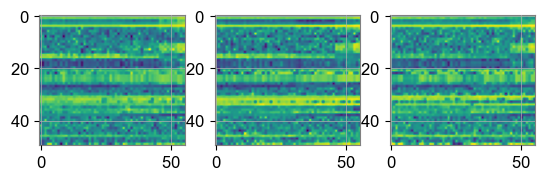

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [14]:
plt.close()
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[0])
ax[1].imshow(fractal_matrices[897])
ax[2].imshow(fractal_matrices[1793])
plt.show()
print(f'Label for fig 1 is {labels[0]}, fig 2 is {labels[897]}, fig 3 is {labels[1793]}')

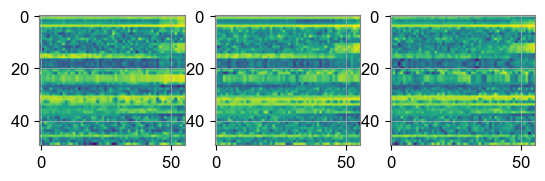

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [15]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[1])
ax[1].imshow(fractal_matrices[898])
ax[2].imshow(fractal_matrices[1794])
plt.show()
print(f'Label for fig 1 is {labels[1]}, fig 2 is {labels[898]}, fig 3 is {labels[1793]}')

In [16]:
fd_mean = np.mean(fractal_matrices, axis=2)
fd_std = np.std(fractal_matrices, axis=2)
fd_max = np.max(fractal_matrices, axis=2)
fd_min = np.min(fractal_matrices, axis=2)
fd_median = np.median(fractal_matrices, axis=2)
fractal_matrices_transformed = np.stack((fd_mean, fd_median, fd_std, fd_min, fd_max), axis=2)
fractal_matrices_transformed.shape

(2688, 50, 5)

## Preprocess data

In [13]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(fractal_matrices, labels, test_size=0.2, random_state=123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
# Verify the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (1720, 50, 56)
X_test shape: (538, 50, 56)
X_val shape: (430, 50, 56)
Y_train shape: (1720,)
Y_test shape: (538,)
Y_val shape: (430,)


In [14]:
label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
#classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
classes = ['Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['Whistle', 'Tomte', 'Scattered_Light']


In [15]:
import torch
from sklearn.preprocessing import LabelEncoder
X_train = torch.from_numpy(X_train).float()  
X_test = torch.from_numpy(X_test).float()
X_val = torch.from_numpy(X_val).float()
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(Y_train)
le.fit(Y_test)
le.fit(Y_val)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(Y_train)
Y_test_encoded = le.transform(Y_test)
Y_val_encoded = le.transform(Y_val)
# Convert the encoded labels to a long tensor
Y_train_labels = torch.from_numpy(Y_train_encoded).long()
Y_test_labels = torch.from_numpy(Y_test_encoded).long()
Y_val_labels = torch.from_numpy(Y_val_encoded).long()

In [16]:
# Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [17]:
#x = torch.randn(16,21,56)
x = torch.randn(16,50,56)
output = model(x)
print(output.shape)

torch.Size([16, 3])


## DL Baseline

In [25]:
import torch.optim as optim

# Define hyperparameters
learning_rate = 0.0001 # reduce it + add early stopping
momentum=0.9
epochs = 100
patience = 4
best_loss = float('inf')
best_epoch = 0
early_stop = False

criterion = CrossEntropyLoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-7, weight_decay=1e-5)

# Loop through epochs
for epoch in range(epochs):
    # Loop through data batches
    for data_X, labels_Y in train_loader:
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_X)
        #print(outputs)
        predicted, _ = torch.max(outputs, 1)
        #print(predicted)
        loss = criterion(predicted, labels_Y.float())  # Convert labels to float for loss calculation

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    #scheduler.step()
    # Print training information (optional)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Check for early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    elif (epoch - best_epoch) >= patience:
        print(f'Early stopping at epoch {epoch+1}, best loss was {best_loss:.4f} at epoch {best_epoch+1}')
        early_stop = True
        break

if not early_stop:
    torch.save(model.state_dict(), 'Models/FD_basline_model.pth')
    print('Best model saved to best_model.pth')
    print('Finished training')

Epoch [1/100], Loss: 34.8015
Epoch [2/100], Loss: 18.8049
Epoch [3/100], Loss: 9.9447
Epoch [4/100], Loss: 12.9091
Epoch [5/100], Loss: 13.1477
Epoch [6/100], Loss: 8.3161
Epoch [7/100], Loss: 17.4011
Epoch [8/100], Loss: 11.3569
Epoch [9/100], Loss: 9.2616
Epoch [10/100], Loss: 19.4813
Early stopping at epoch 10, best loss was 8.3161 at epoch 6


In [26]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 249.76348876953125 ms


In [27]:
y_pred_list

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

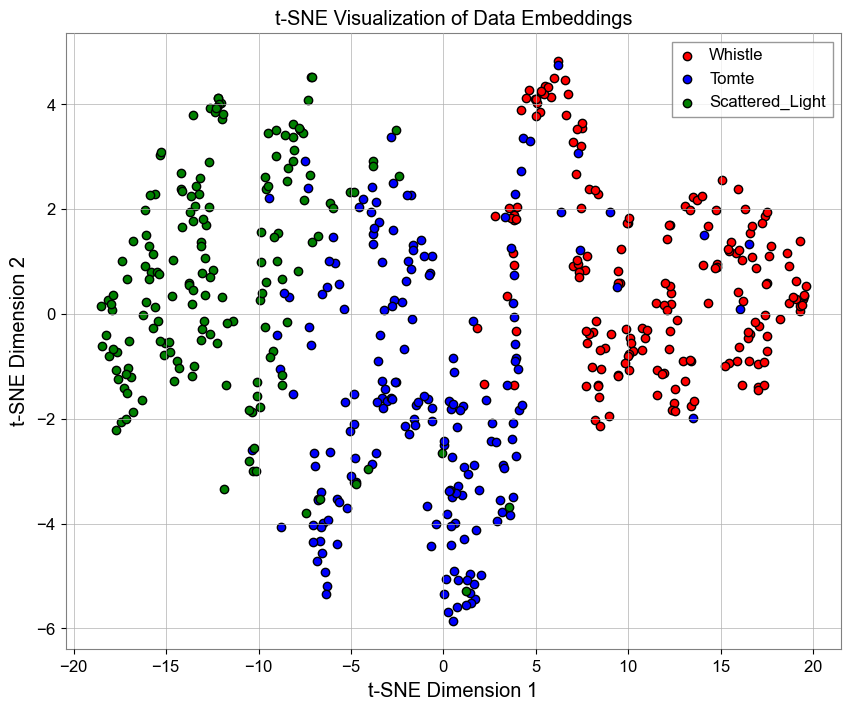

plot_tSNE_data_embedding: 1611.2182140350342 ms


In [28]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_test.png")

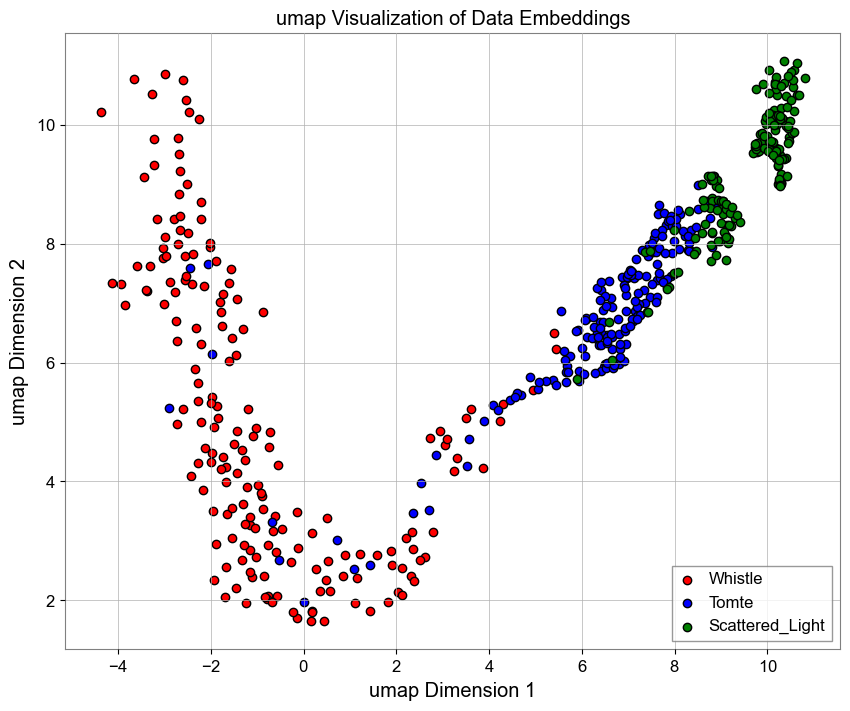

plot_umap_data_embedding: 12764.372110366821 ms


In [29]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_test.png")

In [30]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

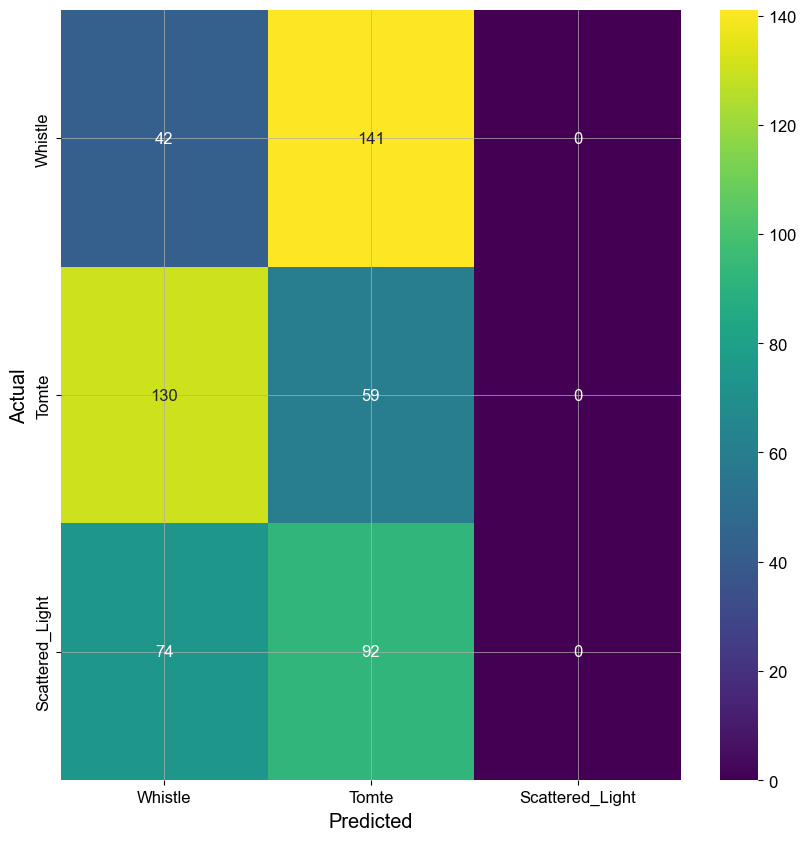

In [31]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model.png')

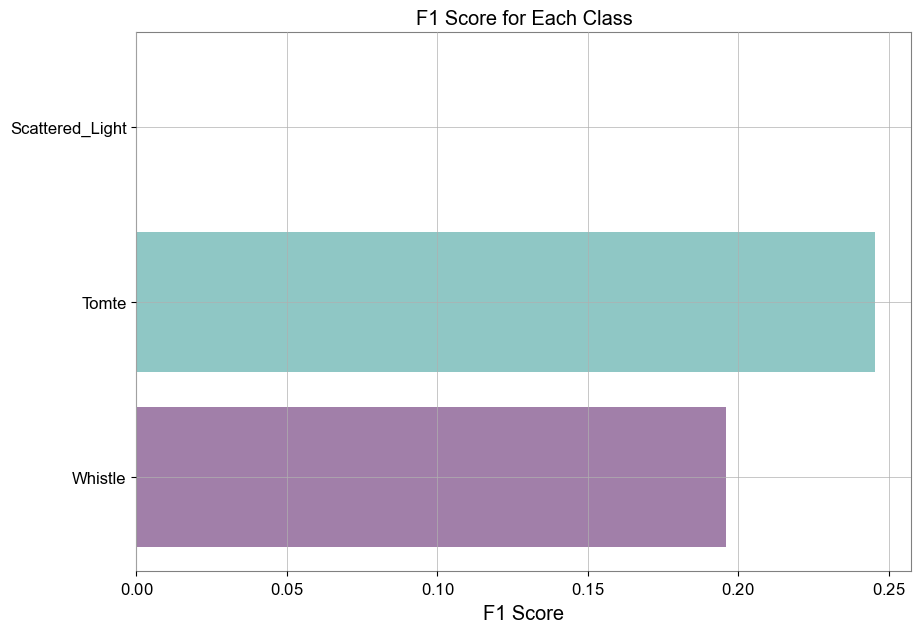

In [32]:
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model.png')

## Naive Continual strategy

In [18]:
### Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         

In [19]:
train_data_av.targets = [label.tolist() for i, label in enumerate(train_data.labels)]
test_data_av.targets = [label.tolist() for i, label in enumerate(test_data.labels)]
val_data_av.targets = [label.tolist() for i, label in enumerate(val_data.labels)]

In [20]:
train_data_av.uniques = list(set(train_data.labels))
test_data_av.uniques = list(set(test_data.labels))
val_data_av.uniques = list(set(val_data.labels))

In [134]:
batch = next(iter(train_data))
matrix, label = batch
print(matrix.shape)
print(label)

torch.Size([50, 56])
tensor(0)


In [21]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

bm = nc_benchmark(
    train_dataset=train_data_av,
    test_dataset=val_data_av,
    n_experiences=3,
    shuffle=True,
    seed=1234,
    task_labels=False
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    #forward_transfer_metrics(experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    mean_scores_metrics(on_train=True, on_eval=True),
    topk_acc_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data)), EarlyStoppingPlugin(patience=2, val_stream_name='Loss_Epoch')]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000002A1BE4C9930>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
60it [00:10,  5.84it/s]                        
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0967
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9718
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9718
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:12<00:00,  2.87it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:12<00:00,  2.84it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/tr

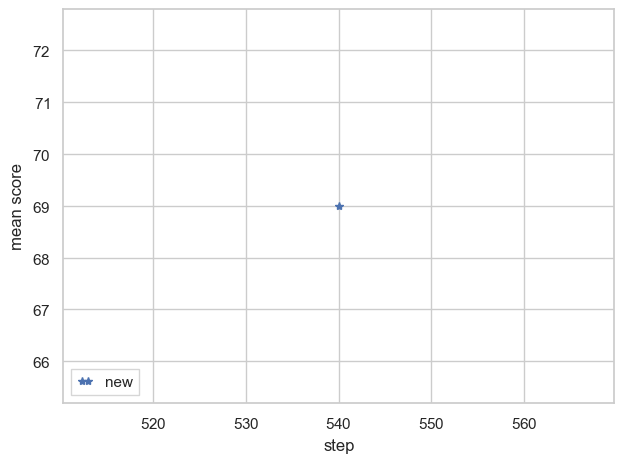

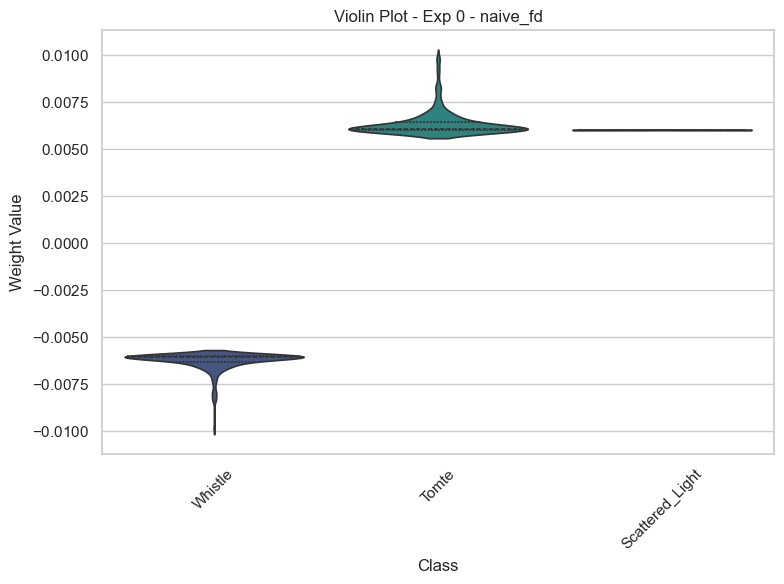

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:04<00:00,  7.60it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.3169
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9056
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9024
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9088
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:04<00:00,  8.11it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1669
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9751
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9743
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9759
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0291
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9931
	Top1_ClassAc

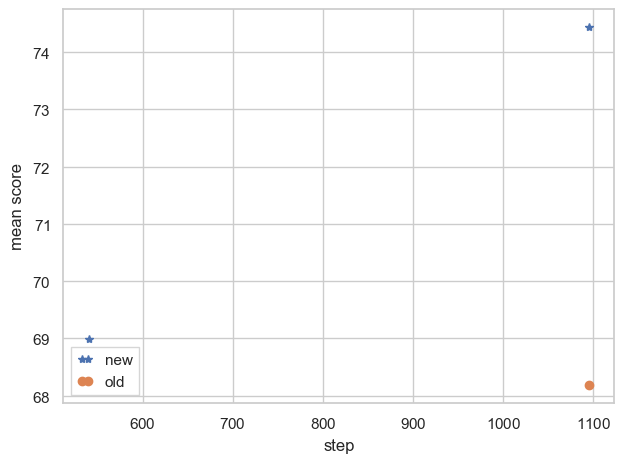

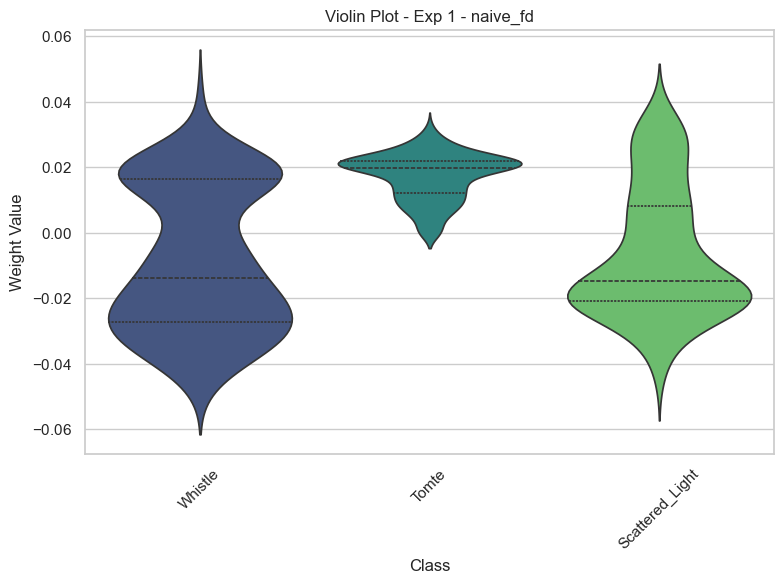

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 40.21it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0130
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9931
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9931
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 45.09it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0002
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/2 = 1.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
-- Starting eval on experienc

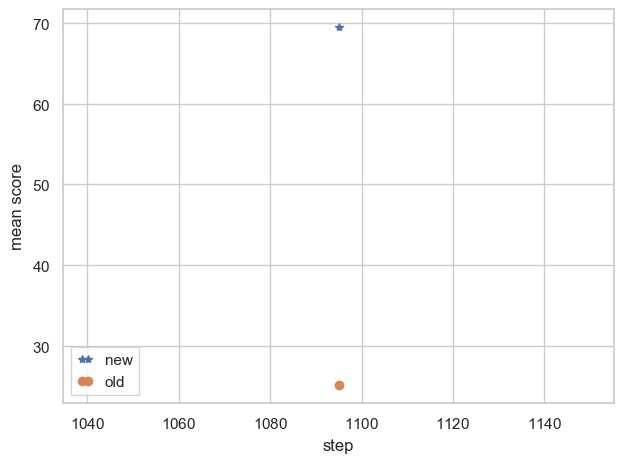

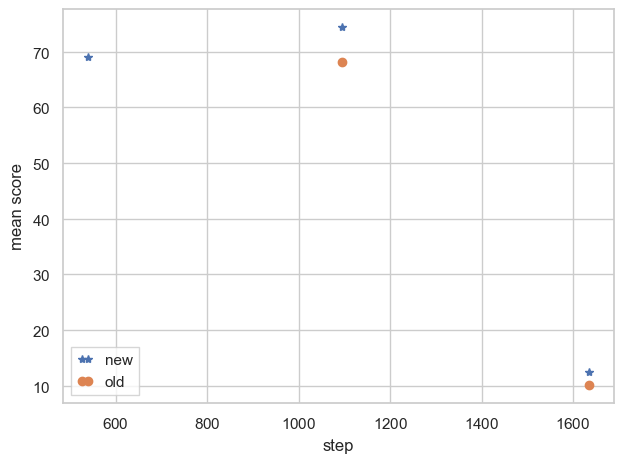

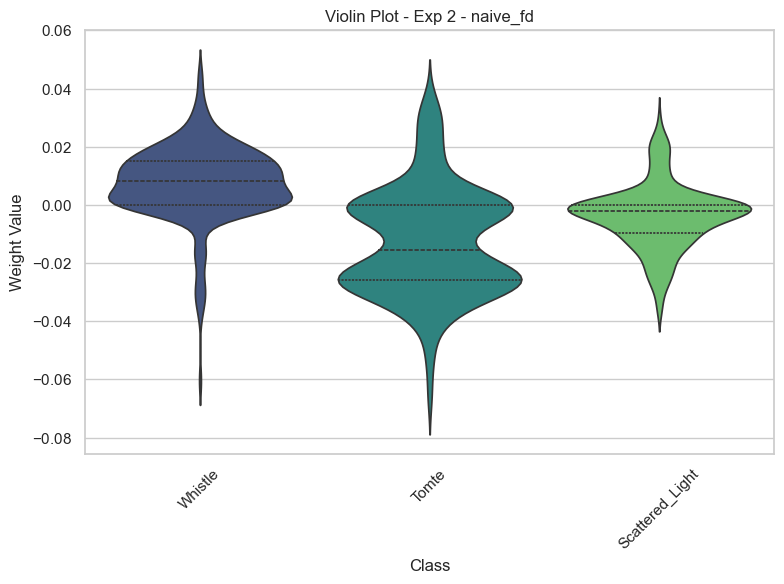

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 49.91it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0965
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9793
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9793
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 57.52it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0537
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0537
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1891
	Top1_Acc_Exp/eval_ph

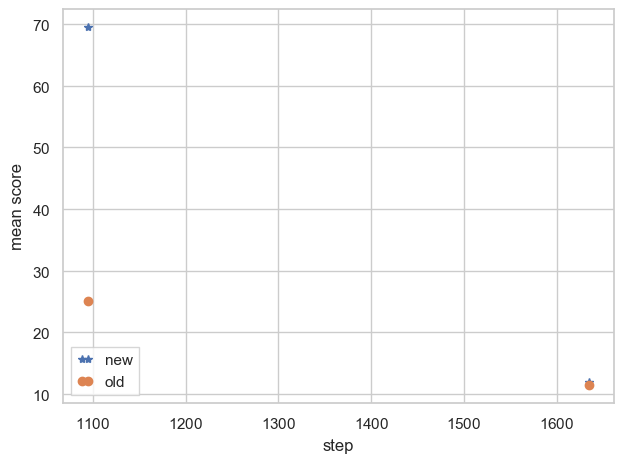

In [76]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fd')

In [77]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 382.34806060791016 ms
                 precision    recall  f1-score   support

        Whistle       0.90      0.98      0.94       183
          Tomte       0.95      0.87      0.91       189
Scattered_Light       0.97      0.97      0.97       166

       accuracy                           0.94       538
      macro avg       0.94      0.94      0.94       538
   weighted avg       0.94      0.94      0.94       538



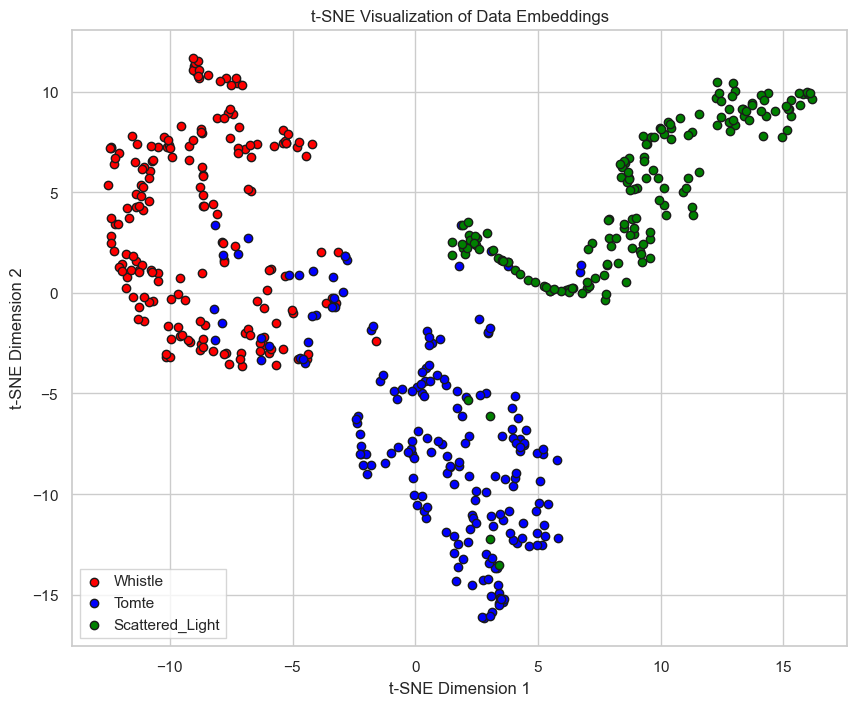

plot_tSNE_data_embedding: 1639.5936012268066 ms


In [78]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_naive_test.png")

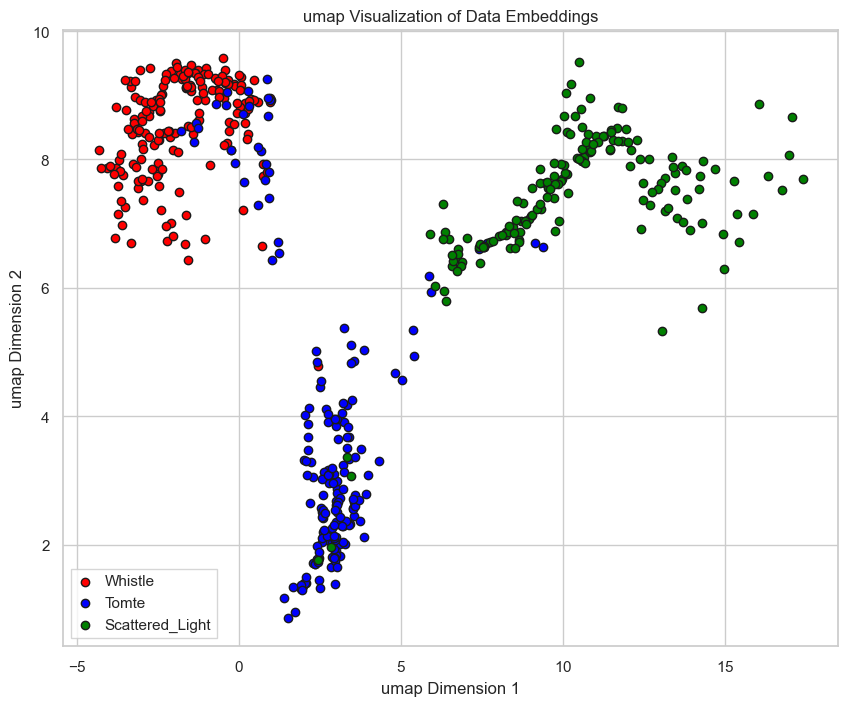

plot_umap_data_embedding: 8930.02963066101 ms


In [79]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_naive_test.png")

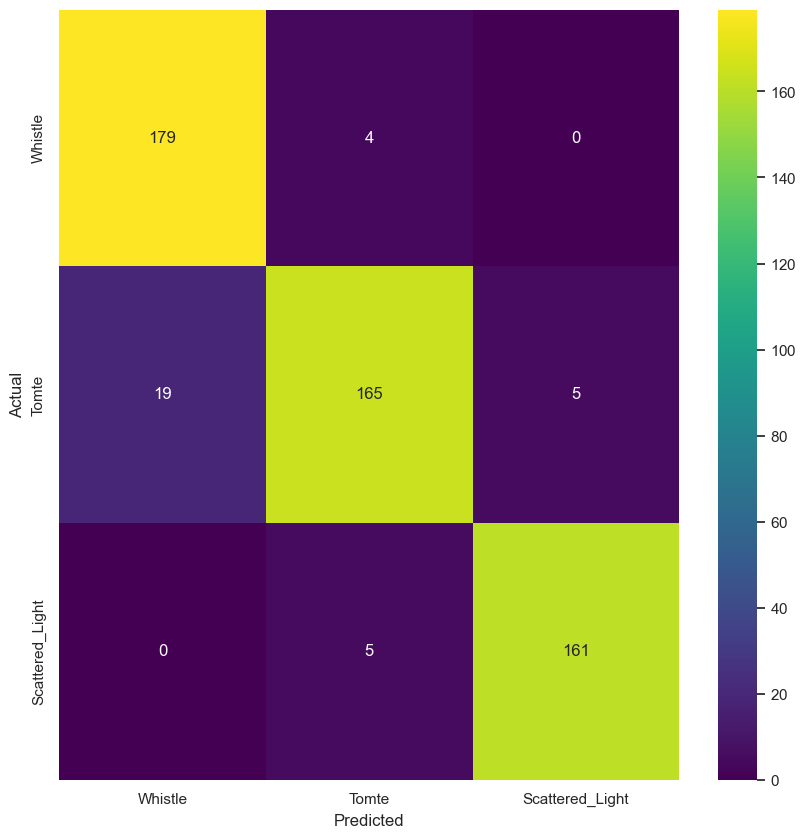

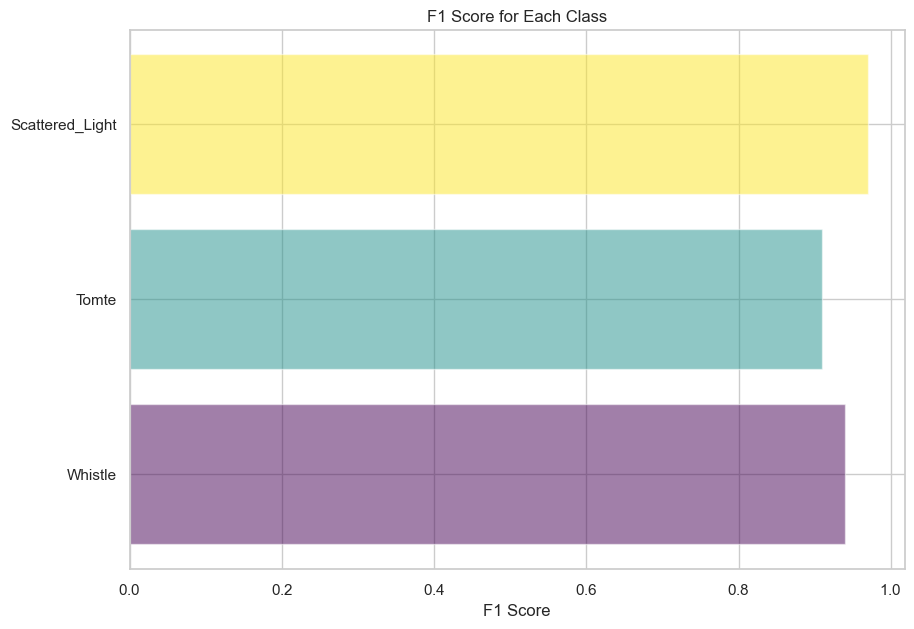

In [82]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model_naive.png')
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model_naive.png')

In [81]:
f1

array([0.93963255, 0.90909091, 0.96987952])

## LwF Continual strategy

In [52]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x000002A1C1870BB0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0634
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9754
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9754
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:03<00:00, 11.64it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000


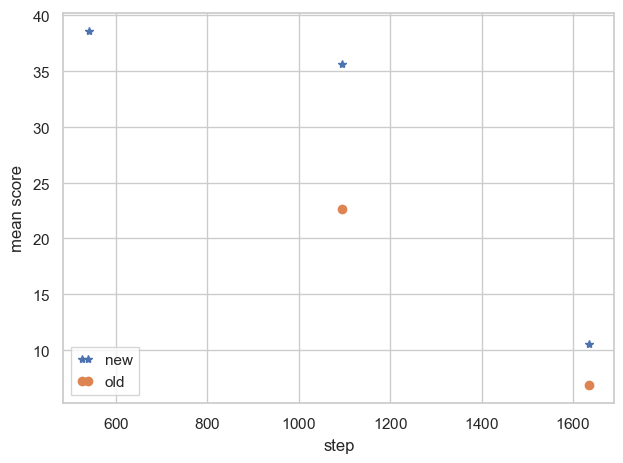

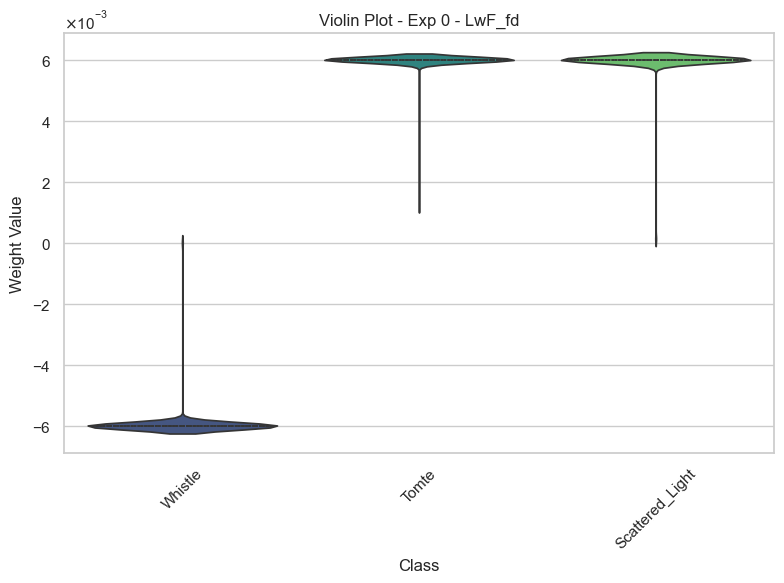

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:04<00:00,  7.85it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.5234
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9176
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9092
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9260
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:04<00:00,  7.70it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0621
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9897
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9932
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9862
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:04<00:00,  8.93it/s]
Epoch 2 en

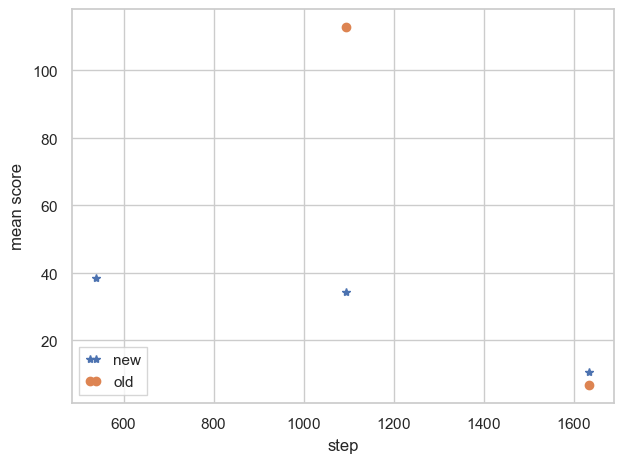

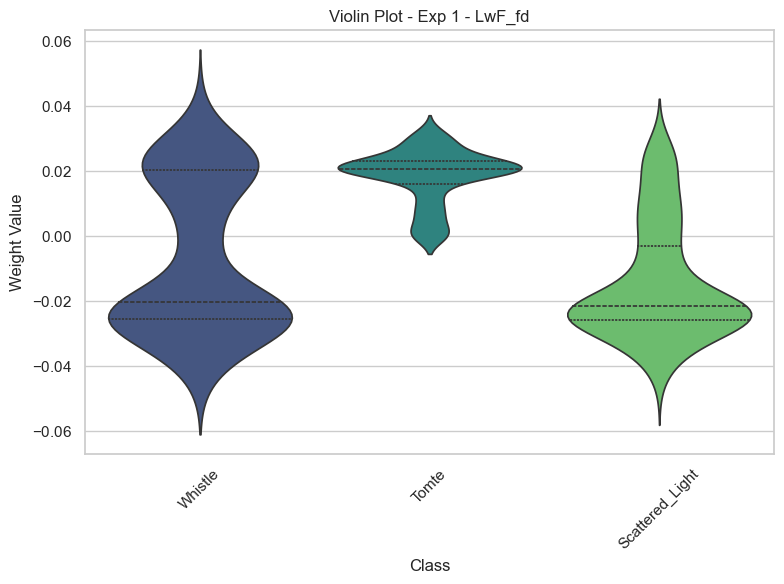

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 88.12it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0160
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9931
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9931
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 79.24it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0884
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9933
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_

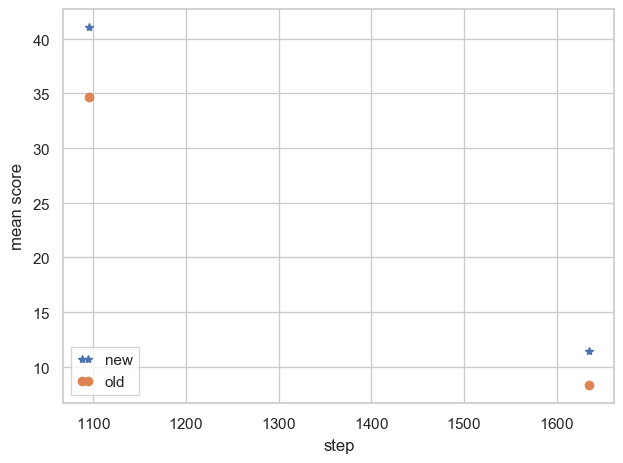

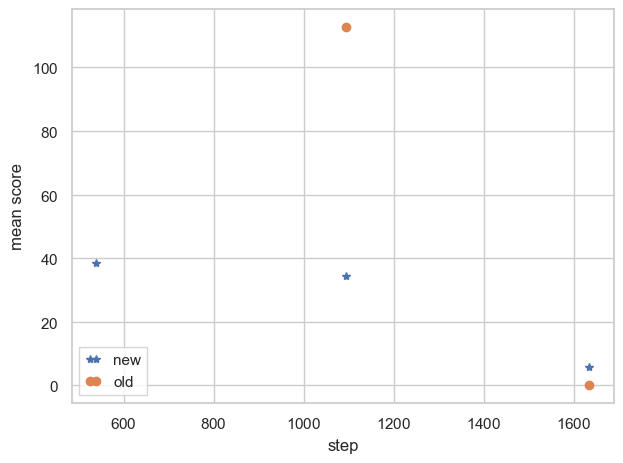

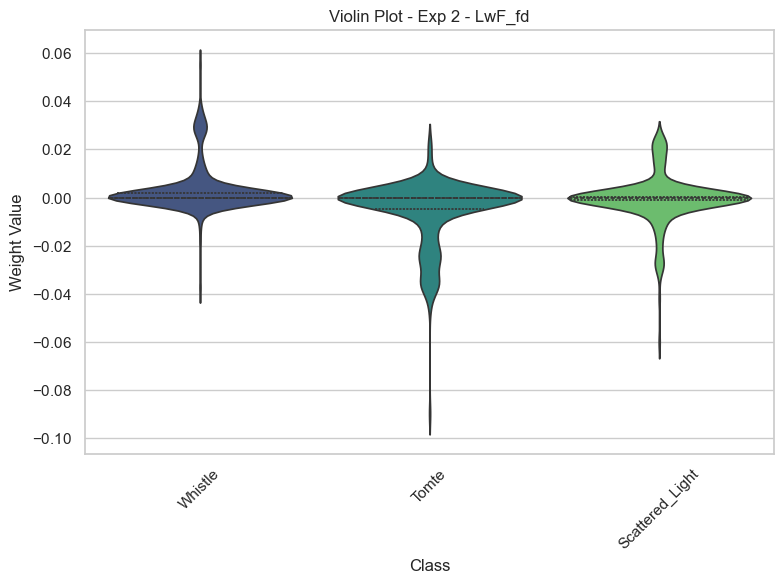

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 77.78it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2988
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9103
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9103
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 72.52it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0738
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0738
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.2719
	Top1_Acc_Exp/eval_ph

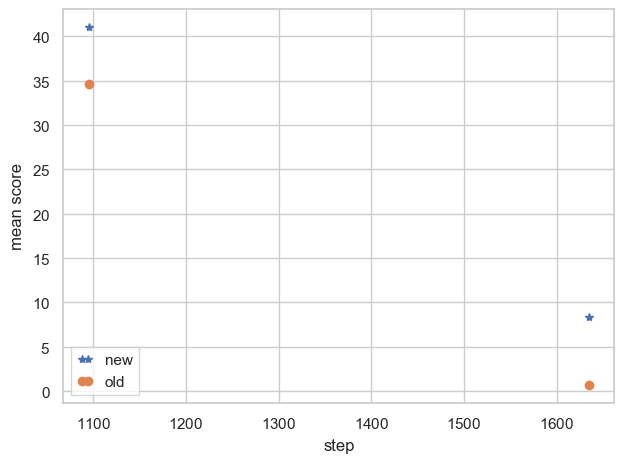

In [53]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'LwF_fd')

In [54]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 258.1033706665039 ms
                 precision    recall  f1-score   support

        Whistle       0.93      0.91      0.92       183
          Tomte       0.87      0.92      0.89       189
Scattered_Light       0.98      0.95      0.96       166

       accuracy                           0.92       538
      macro avg       0.93      0.92      0.93       538
   weighted avg       0.93      0.92      0.92       538



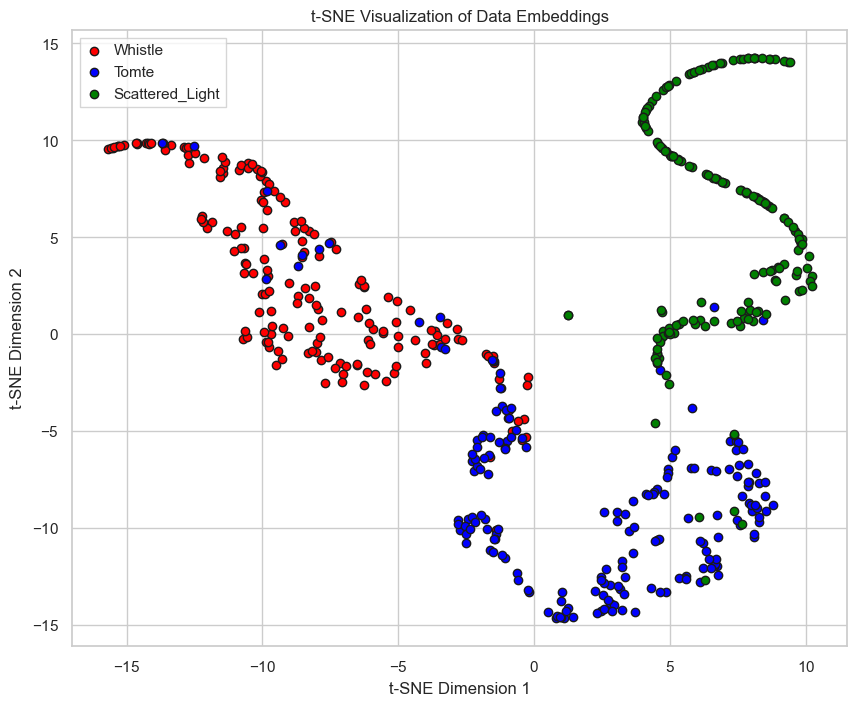

plot_tSNE_data_embedding: 1486.1857891082764 ms


In [122]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_LwF_test.png")

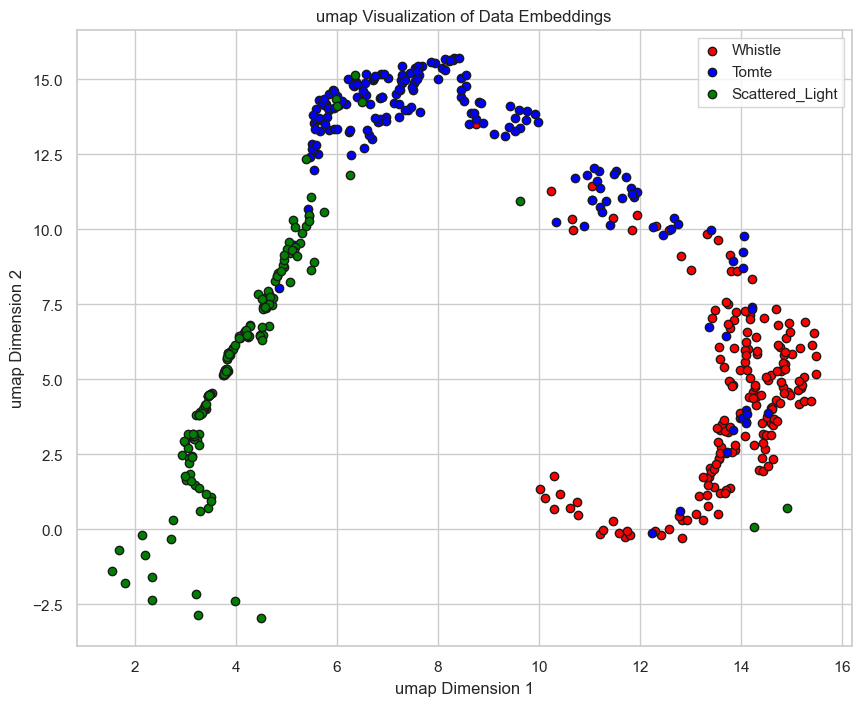

plot_umap_data_embedding: 7328.517436981201 ms


In [123]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_LwF_test.png")

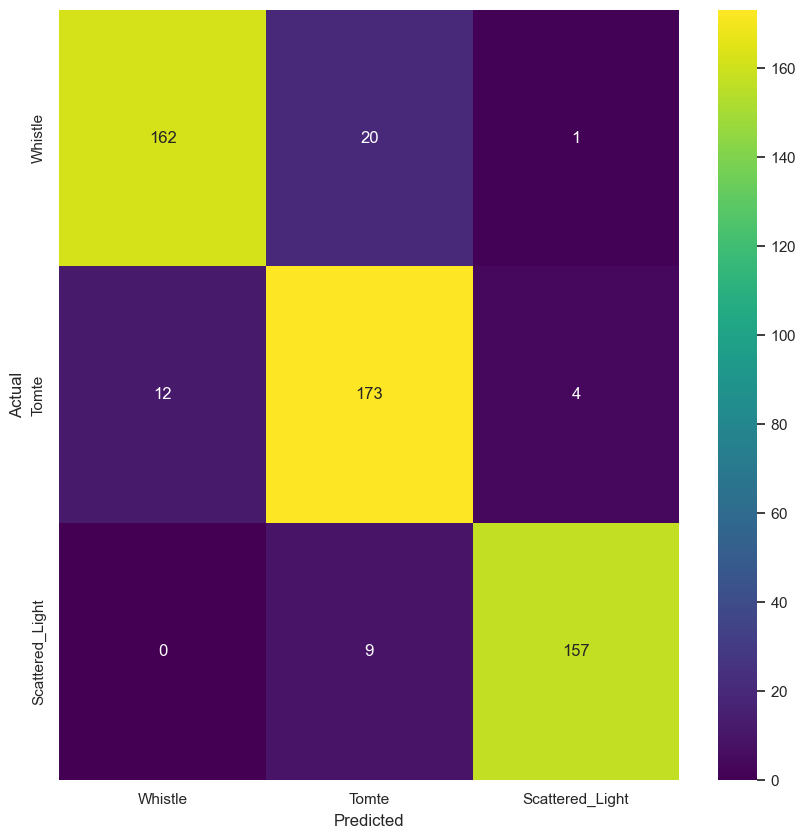

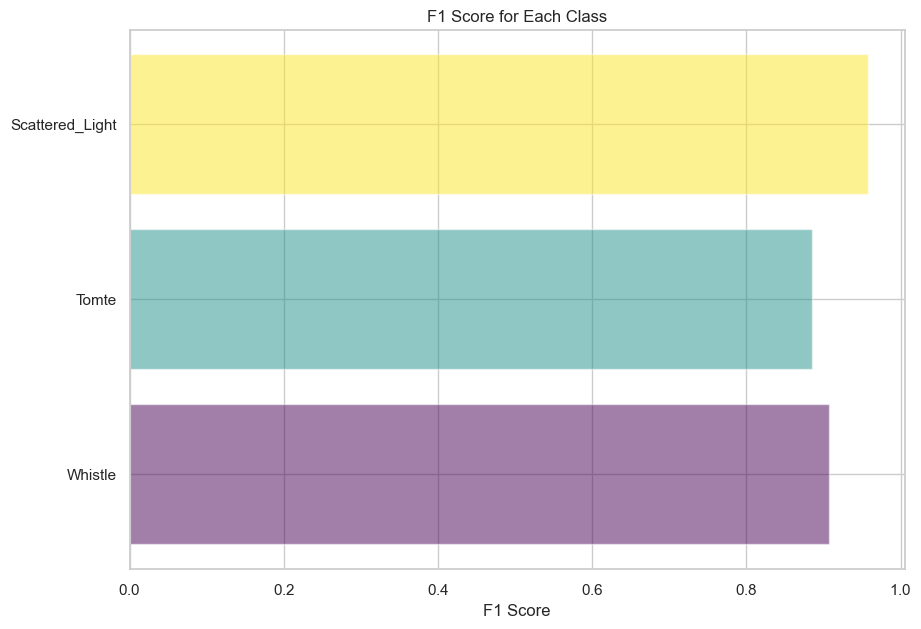

In [124]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_LwF.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_LwF.png')

## AGEM Continual Strategy

In [38]:
mem_size = int(0.1*(len(train_data)))
print(mem_size)

172


In [39]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=20,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=mem_size), AGEMPlugin(patterns_per_experience=20, sample_size=16)]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x000002A1AB2AB2B0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 14.06it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0412
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9859
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9859
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 13.48it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000

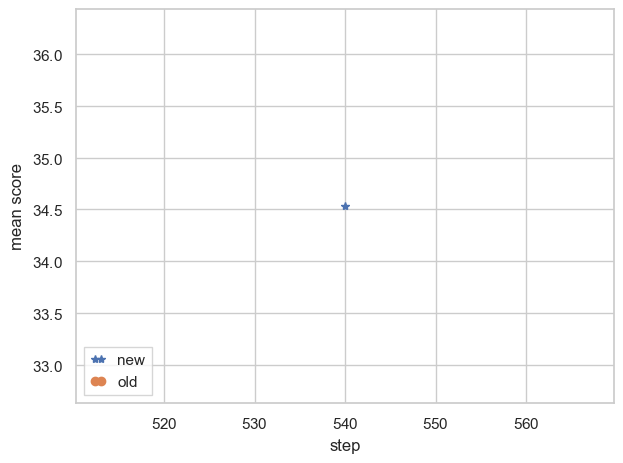

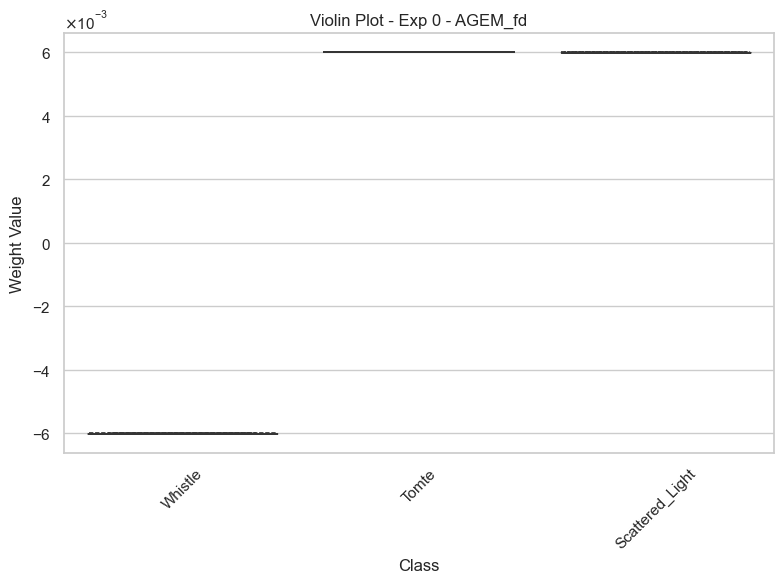

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:07<00:00,  5.05it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7166
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9483
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.4854
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:06<00:00,  6.11it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4996
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:06<00:00,  5.54it/s]
Epoch 2 ended.
	

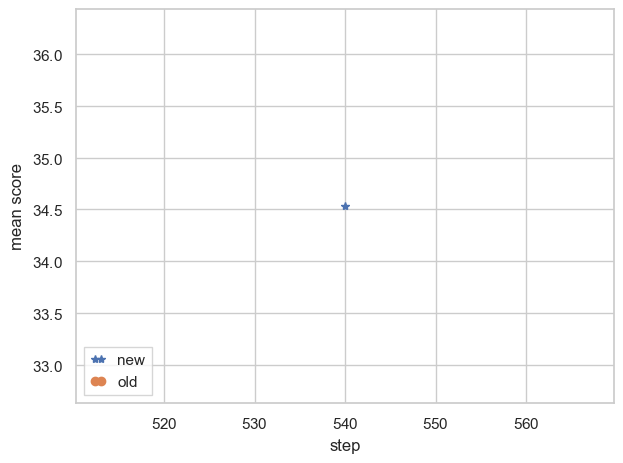

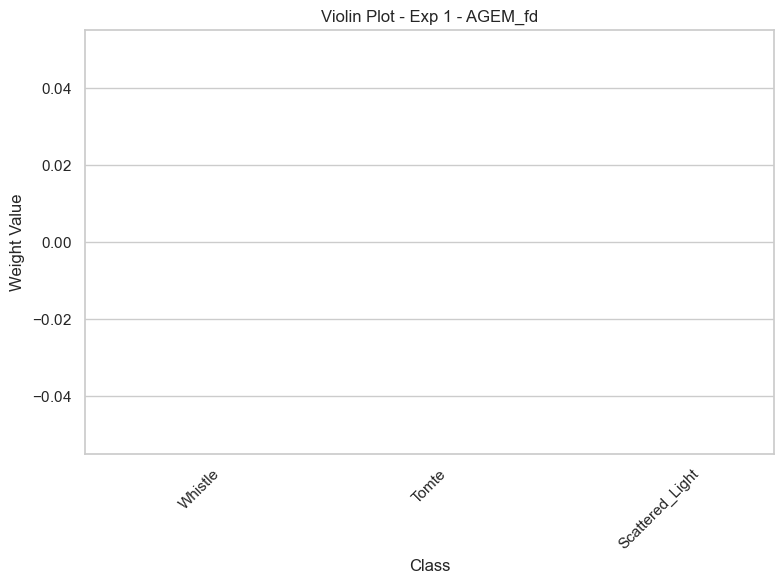

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 65.82it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = nan
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 71.91it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = nan
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/

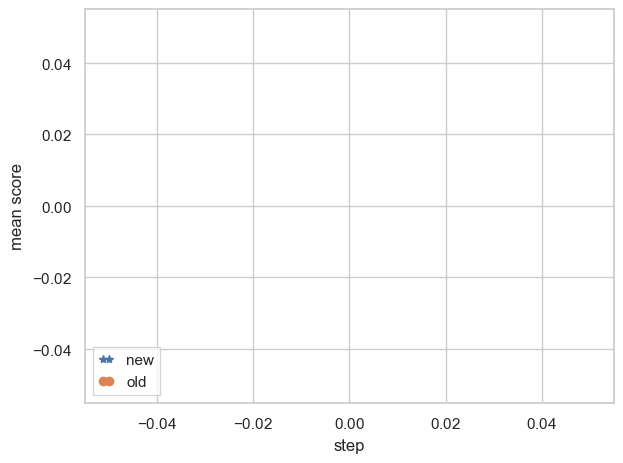

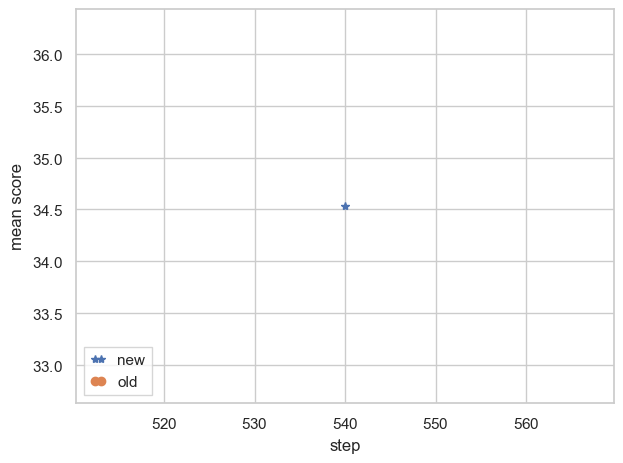

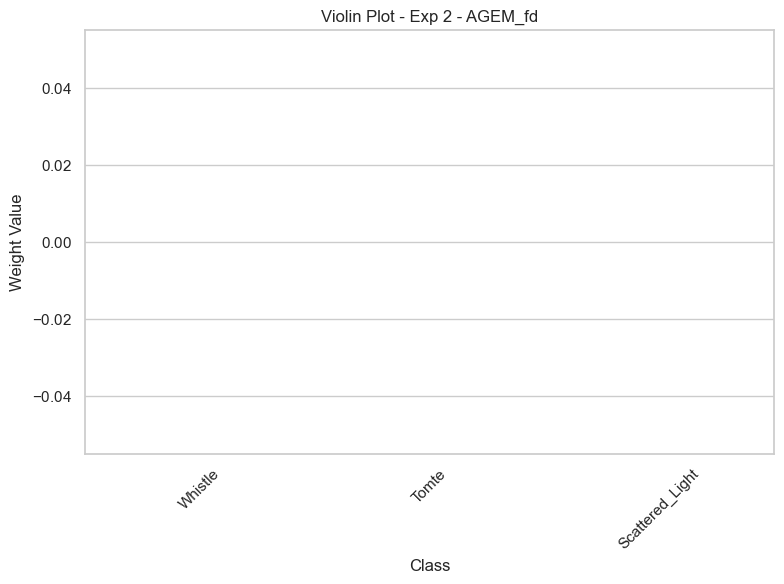

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 81.48it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = nan
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 76.40it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0000
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0000
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = nan
	Top1_Acc_Exp/eval_phase/te

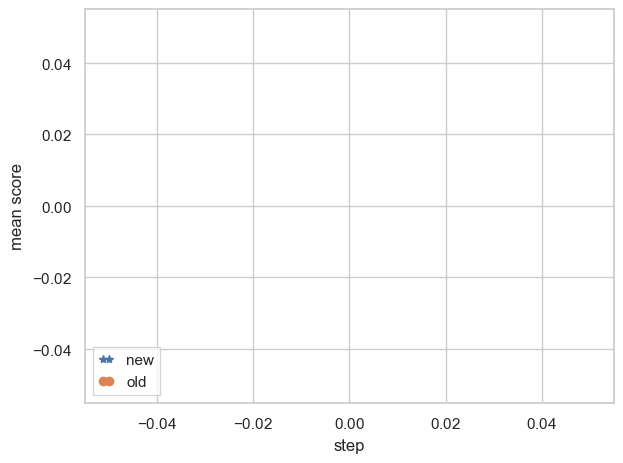

In [40]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'AGEM_fd', scr=False)

In [41]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 281.8489074707031 ms


In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_AGEM_test.png")

In [ ]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_AGEM_test.png")

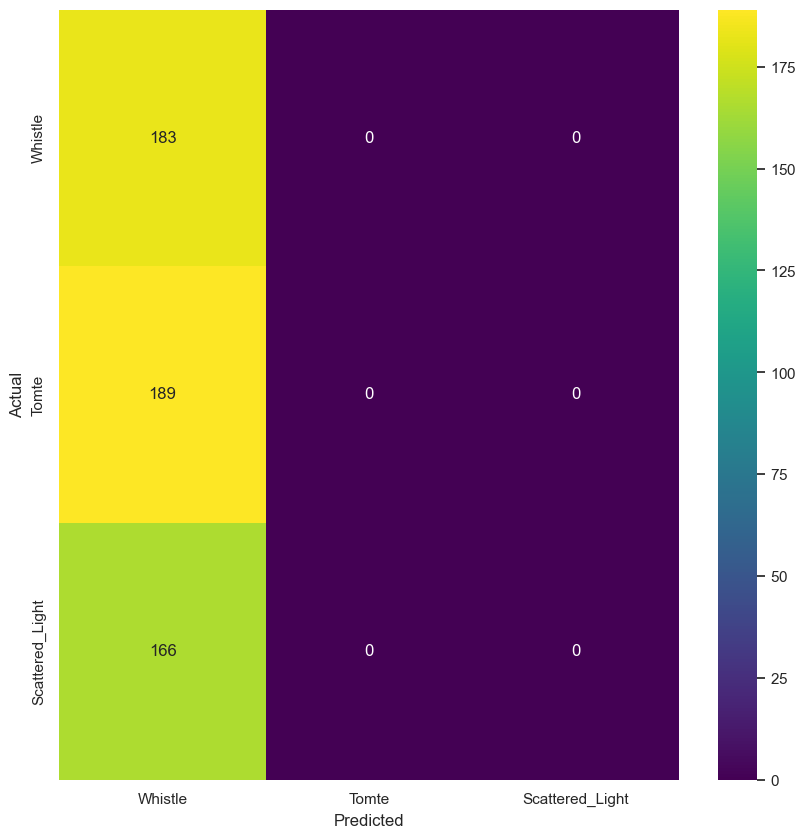

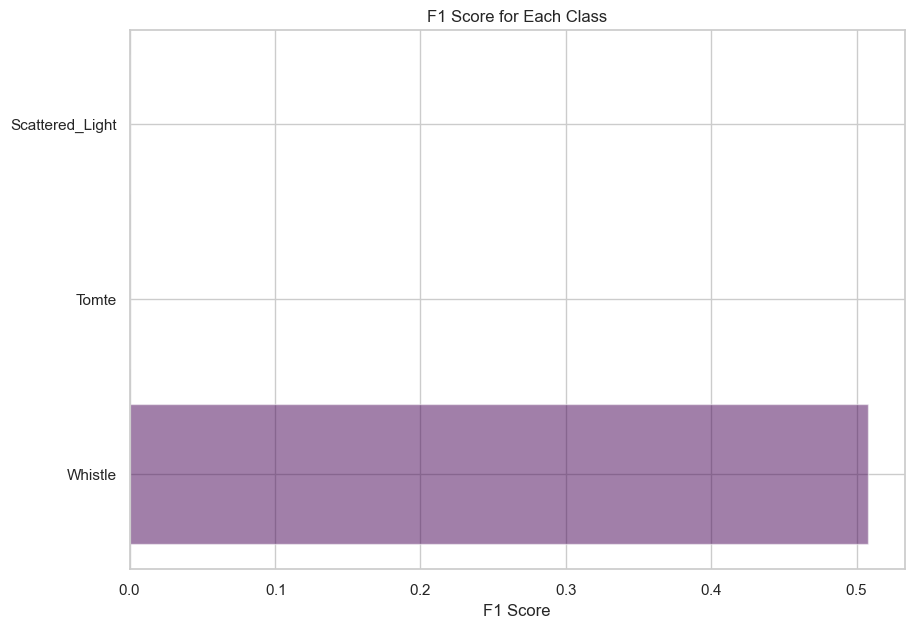

In [44]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_AGEM.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_AGEM.png')

## EWC Continual Strategy

In [55]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = EWC(
    model=model, optimizer=optimizer, criterion=criterion, ewc_lambda=0.1,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_data))]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.EWC object at 0x000002A1BC1223E0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:03<00:00, 11.11it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0151
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9947
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9947
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:04<00:00,  7.91it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000


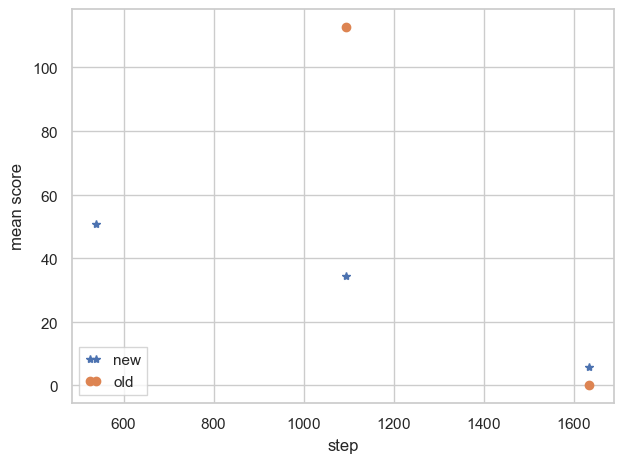

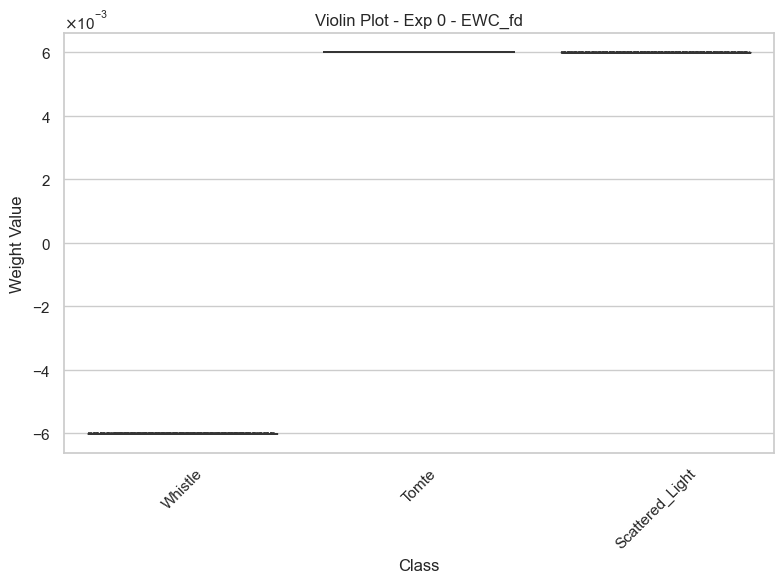

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:05<00:00,  6.81it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.7270
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8936
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9041
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.8830
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:06<00:00,  5.55it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2062
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9803
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9760
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9845
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:05<00:00,  6.40it/s]
Epoch 2 en

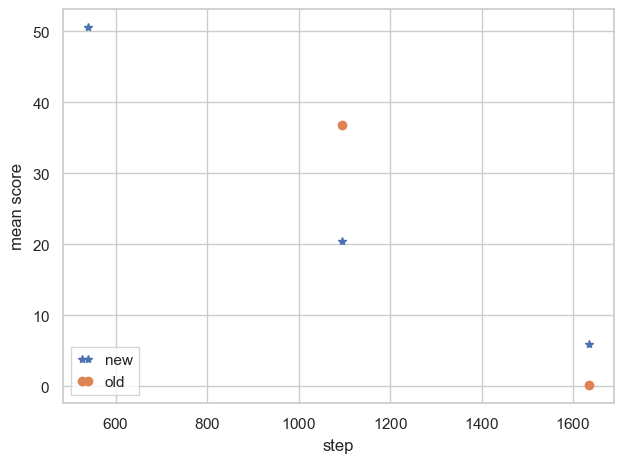

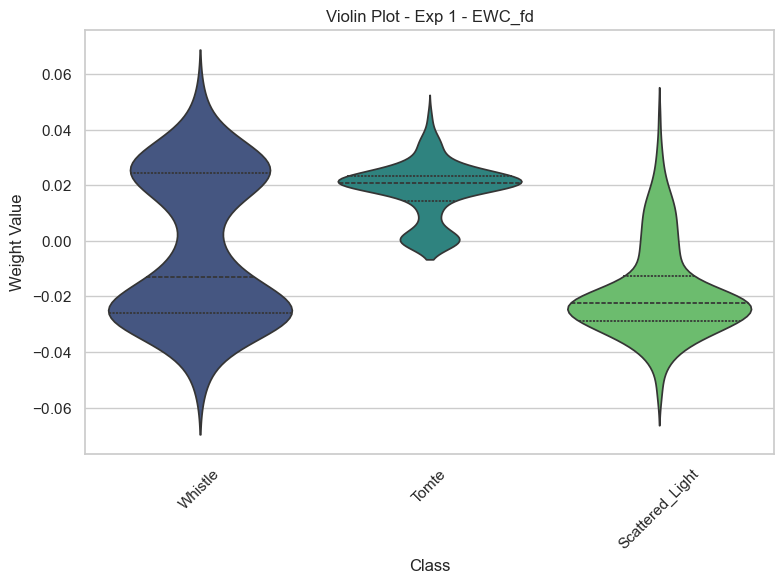

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 93.27it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0035
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 80.18it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0094
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_

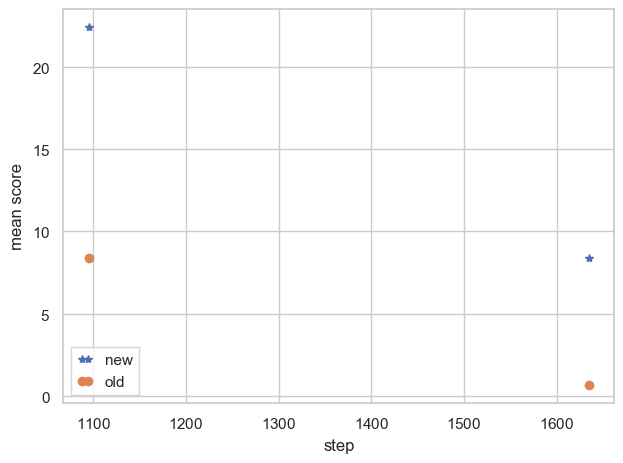

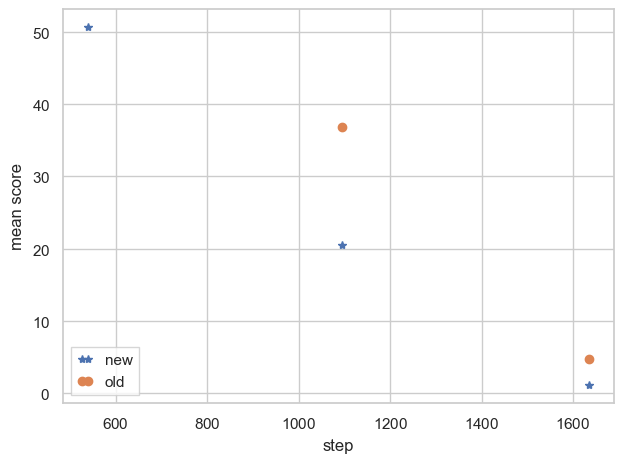

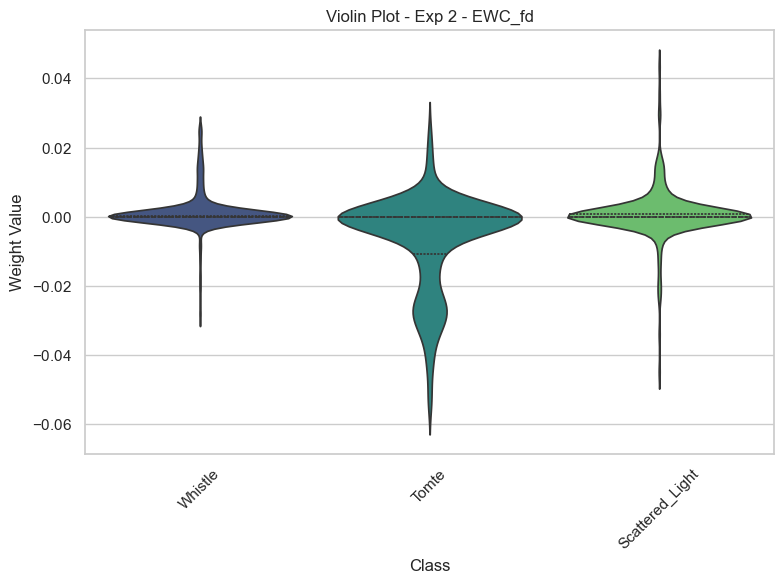

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 92.00it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2346
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9655
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9655
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 80.59it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.1879
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1879
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6146
	Top1_Acc_Exp/eval_ph

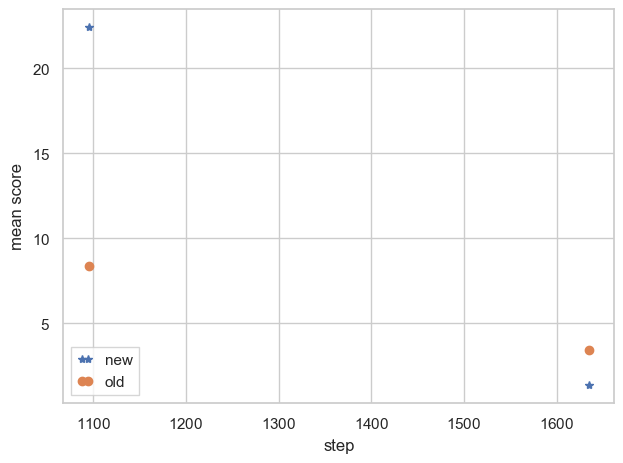

In [56]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'EWC_fd', scr=False)

In [57]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 221.20094299316406 ms
                 precision    recall  f1-score   support

        Whistle       0.89      0.93      0.91       183
          Tomte       0.85      0.87      0.86       189
Scattered_Light       0.97      0.90      0.94       166

       accuracy                           0.90       538
      macro avg       0.91      0.90      0.90       538
   weighted avg       0.90      0.90      0.90       538



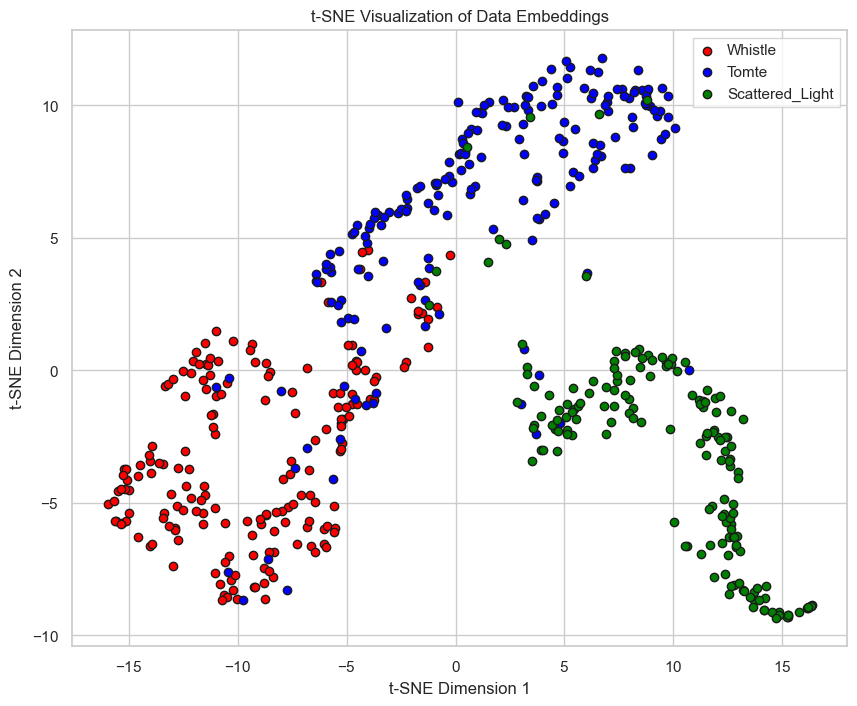

plot_tSNE_data_embedding: 1703.432559967041 ms


In [58]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_EWC_test.png")

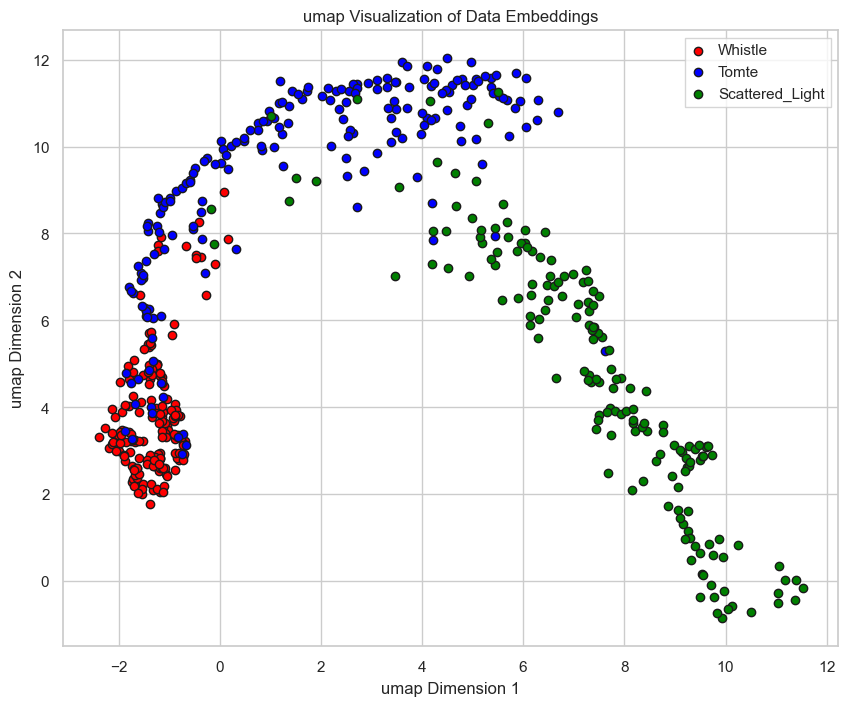

plot_umap_data_embedding: 12828.36365699768 ms


In [59]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_EWC_test.png")

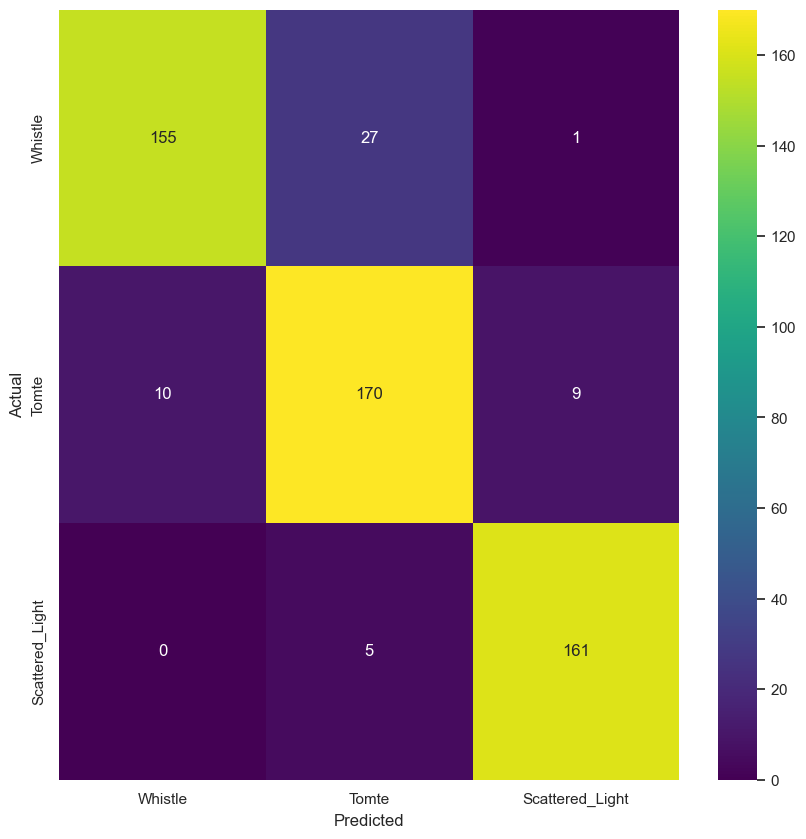

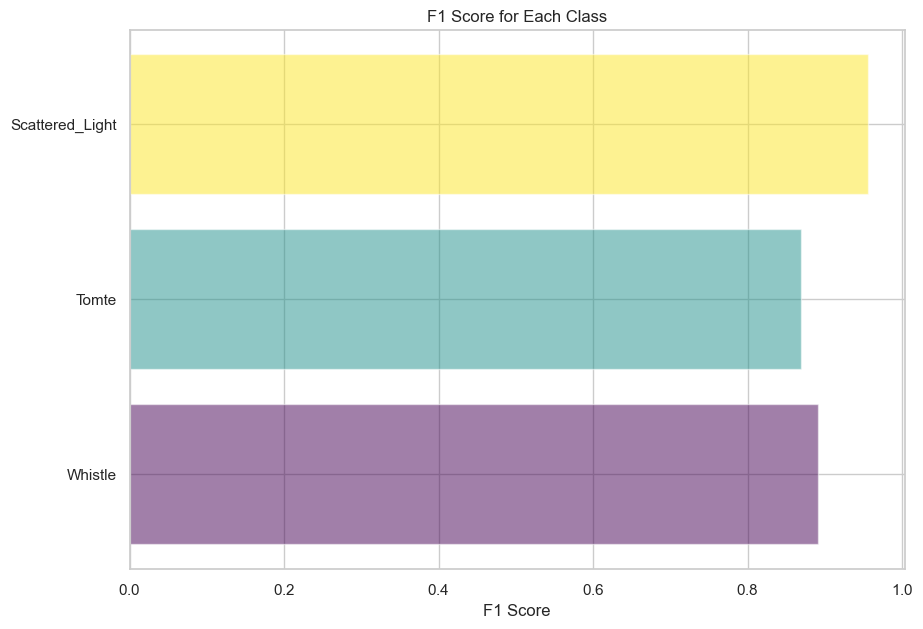

array([0.8908046 , 0.86956522, 0.95548961])

In [38]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_EWC.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_EWC.png')
f1

## DER Continual Strategy

In [30]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=1.0, beta=0, mem_size=500,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

model.to(device)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x000001B8B63F04C0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:03<00:00,  9.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0088
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:04<00:00,  8.44it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Ep

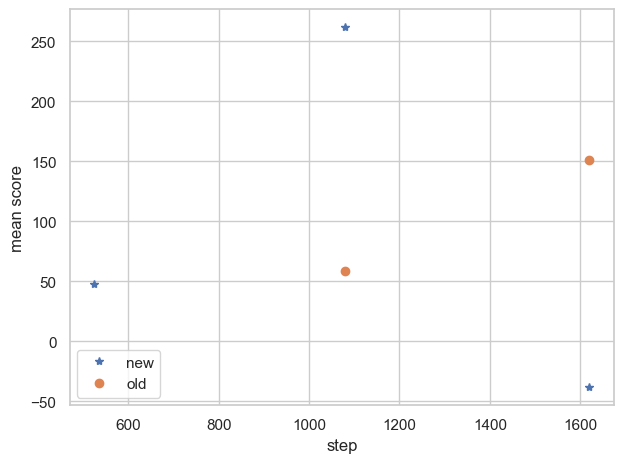

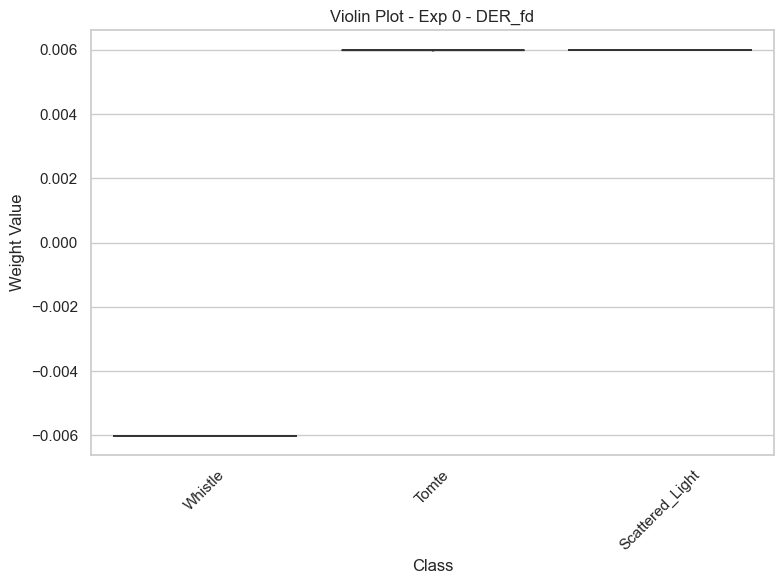

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:03<00:00, 10.64it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 341.7478
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7829
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9443
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.6216
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00,  9.71it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 60.8982
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8547
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9966
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.7128
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00, 10.78it/s]
Epoch 2

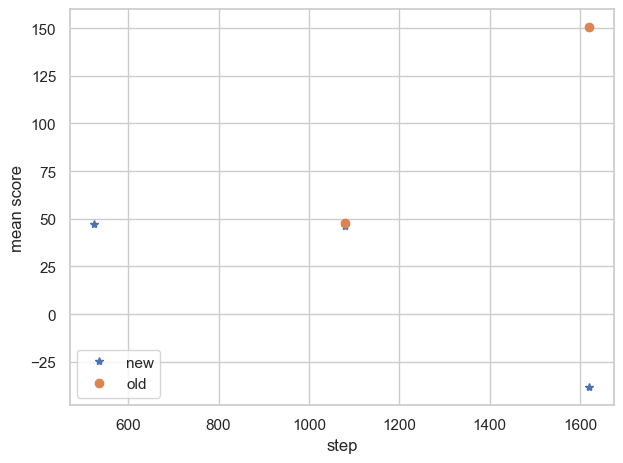

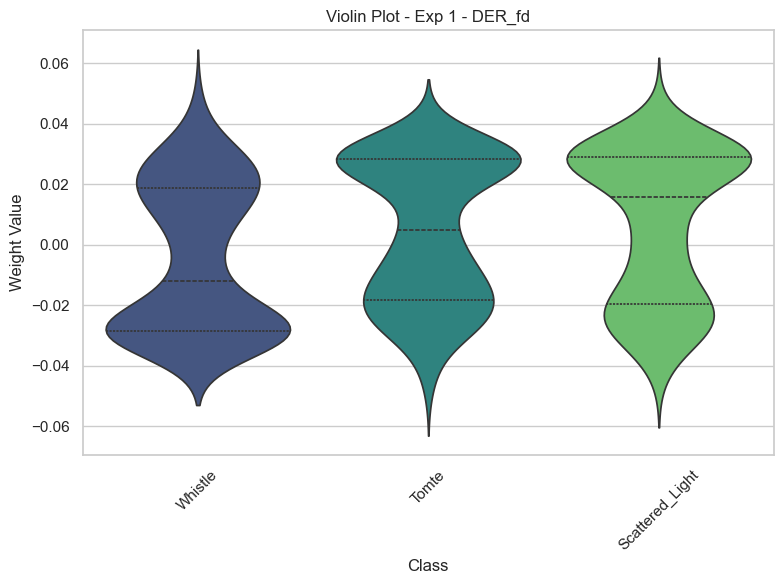

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 64.35it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0001
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 9/9 [00:00<00:00, 59.66it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.4750
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9783
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_ph

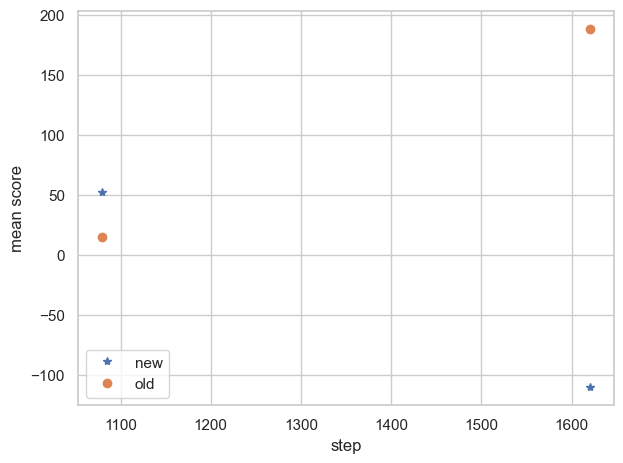

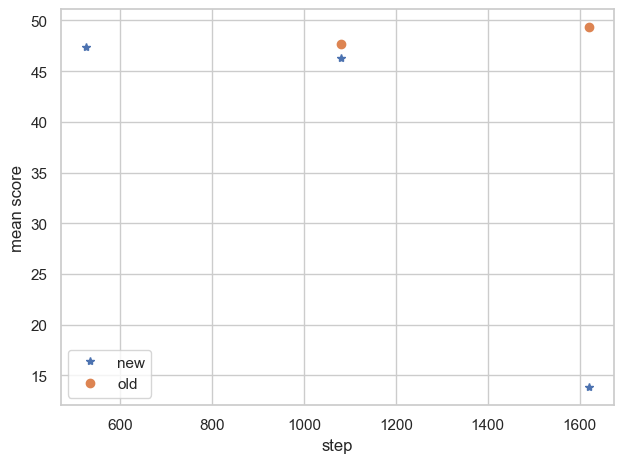

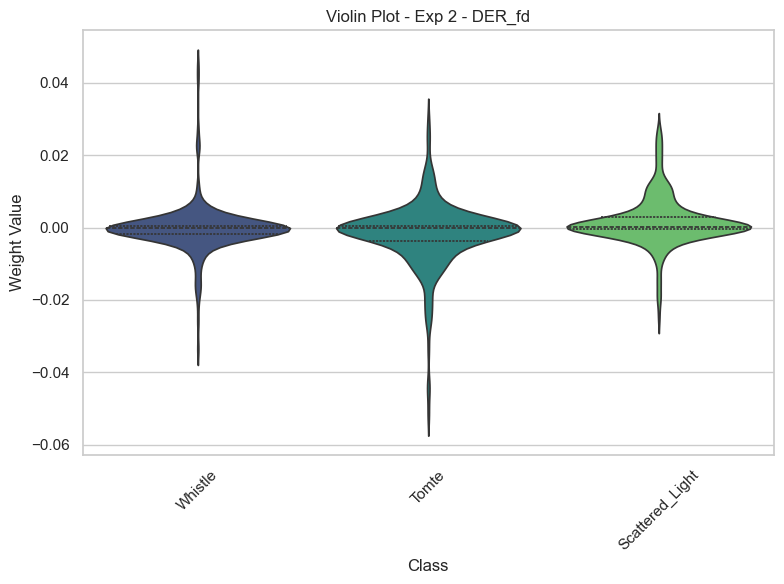

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 90.43it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0000
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 9/9 [00:00<00:00, 81.80it/s] 
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0145
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0145
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 1.2990
	Top1_Acc_Exp/eval_pha

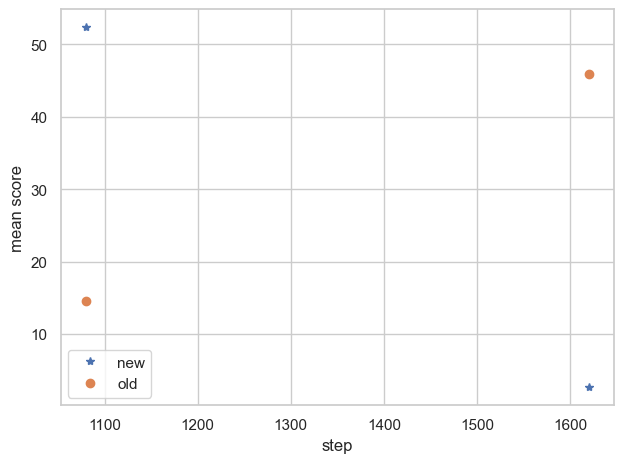

In [31]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER_fd', scr=False)

In [32]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 304.1377067565918 ms
                 precision    recall  f1-score   support

        Whistle       0.72      1.00      0.84       183
          Tomte       0.96      0.53      0.68       189
Scattered_Light       0.89      0.96      0.92       166

       accuracy                           0.82       538
      macro avg       0.86      0.83      0.81       538
   weighted avg       0.86      0.82      0.81       538



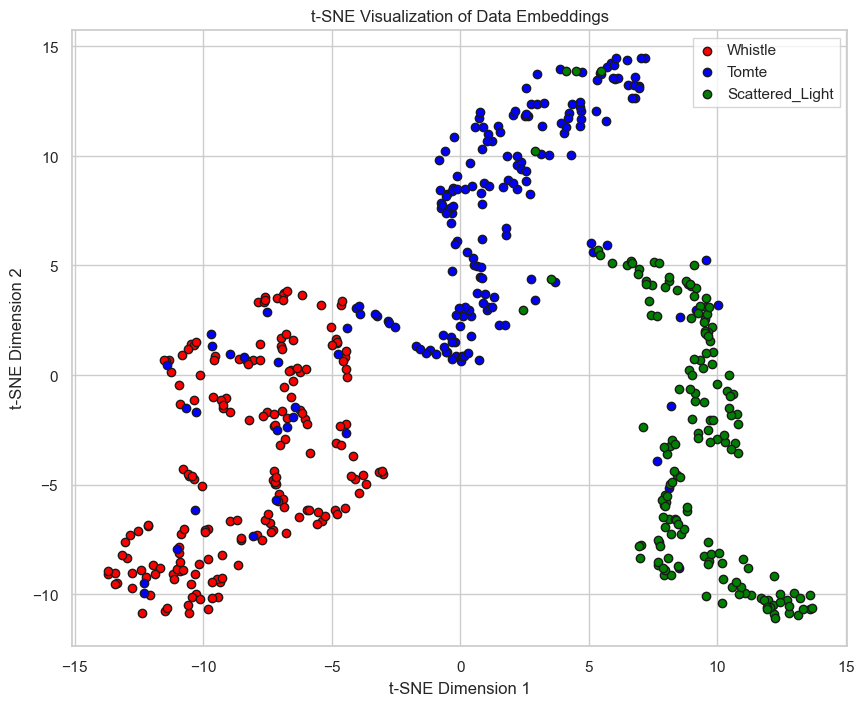

plot_tSNE_data_embedding: 1495.1562881469727 ms


In [146]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_DER_test.png")

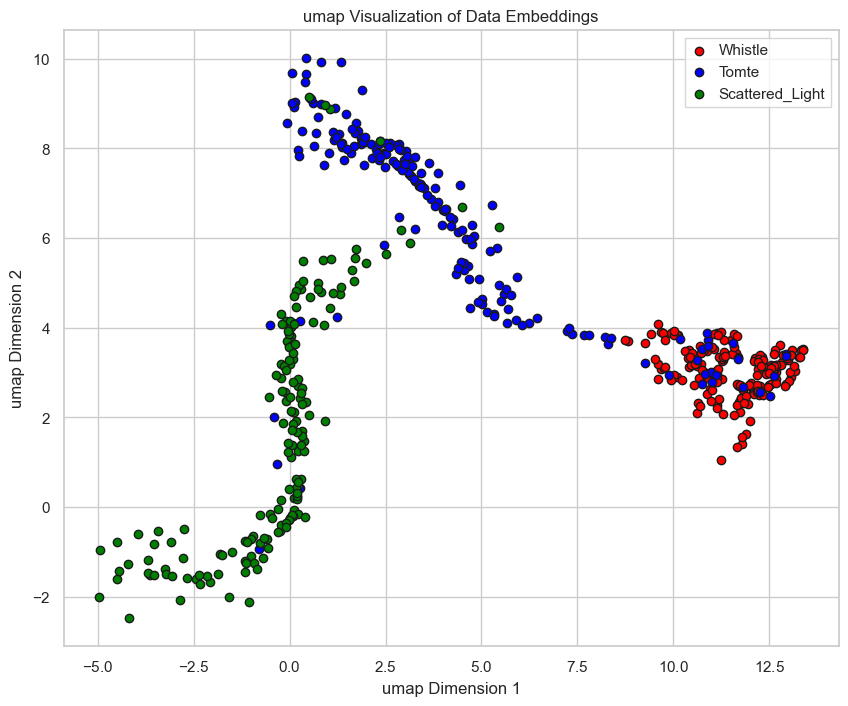

plot_umap_data_embedding: 7341.6337966918945 ms


In [147]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_DER_test.png")

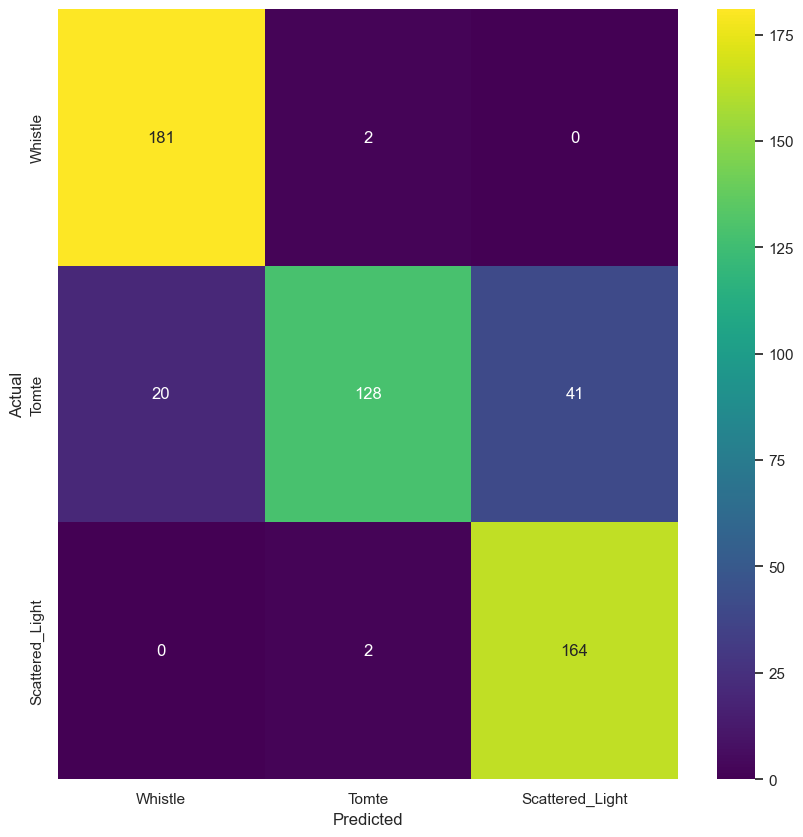

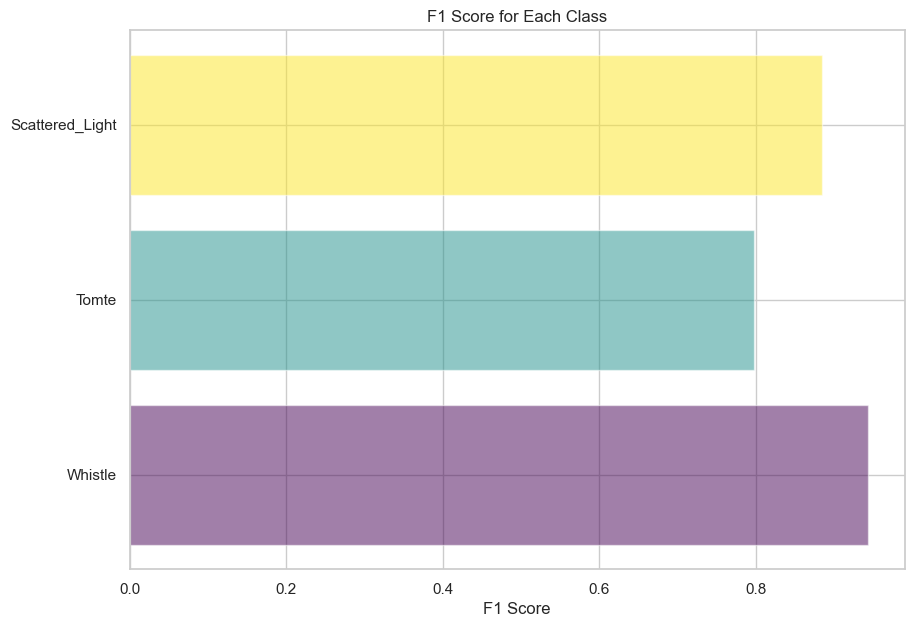

In [26]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_DER.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_DER.png')

## DER++ Continual strategy

In [149]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY DER++
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.5, beta=1.0, mem_size=500,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x000002A1C09427A0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:02<00:00, 12.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0277
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9862
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9862
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00,  9.53it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Ep

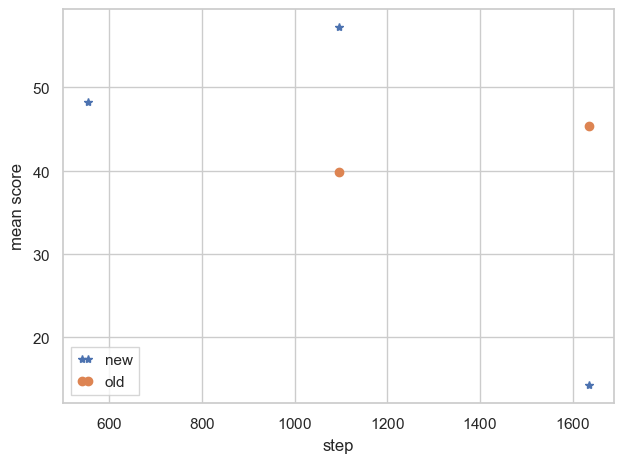

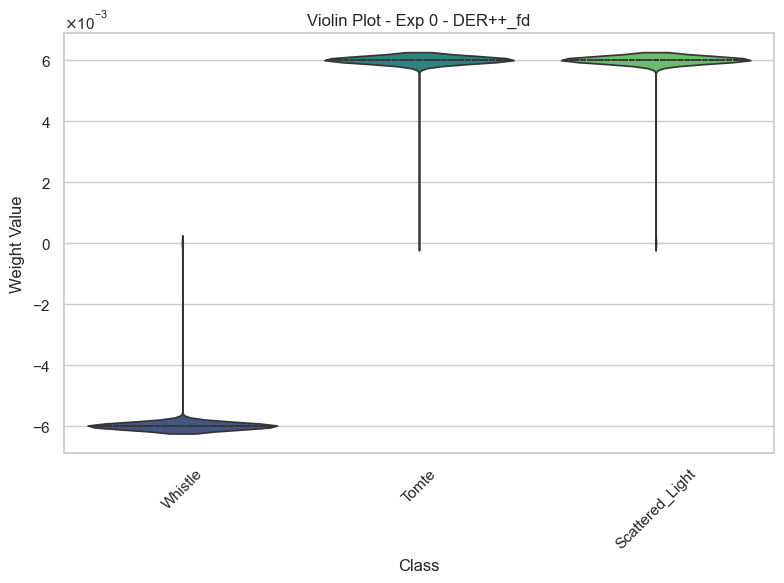

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:03<00:00, 11.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 141.8040
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8749
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9688
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.7795
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:03<00:00,  9.04it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 13.8592
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9545
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9983
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9101
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:03<00:00, 10.04it/s]
Epoch 2

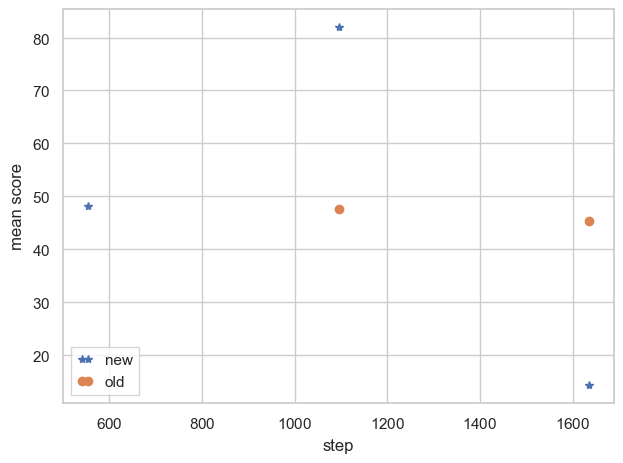

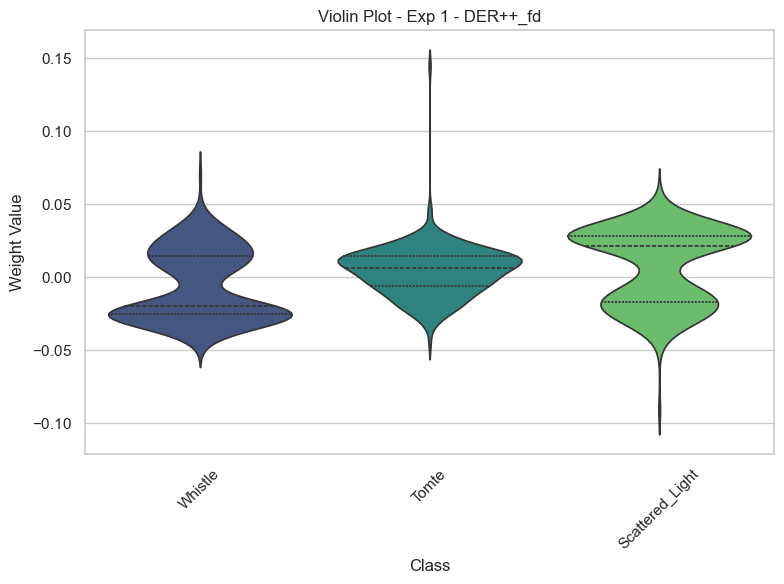

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 9/9 [00:00<00:00, 79.24it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0429
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9925
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9925
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 11/11 [00:00<00:00, 71.99it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp001/0 = 0.0000
	Top1_ClassAcc_Exp/eval_ph

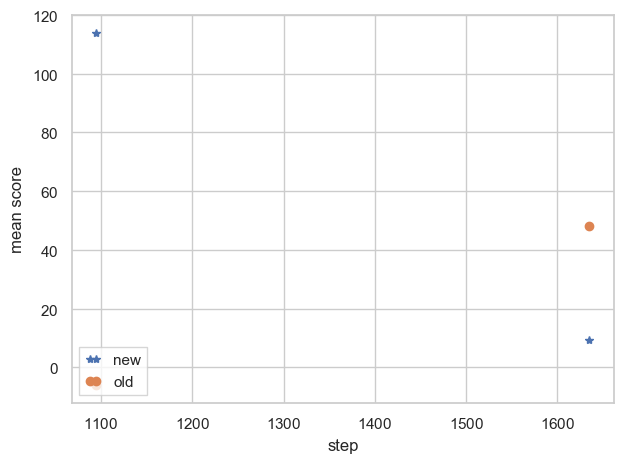

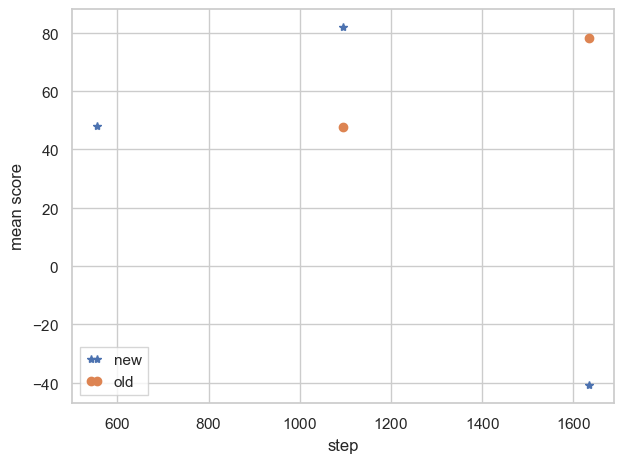

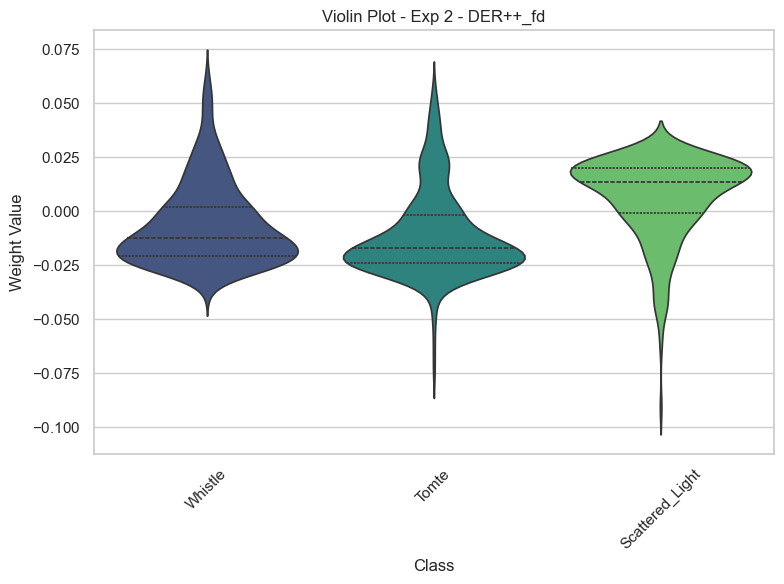

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 9/9 [00:00<00:00, 86.71it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0359
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9925
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0 = 0.9925
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1 = 0.0000
	Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2 = 0.0000
	Topk_3_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 11/11 [00:00<00:00, 83.45it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0123
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0123
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.2398
	Top1_Acc_Exp/eval_phas

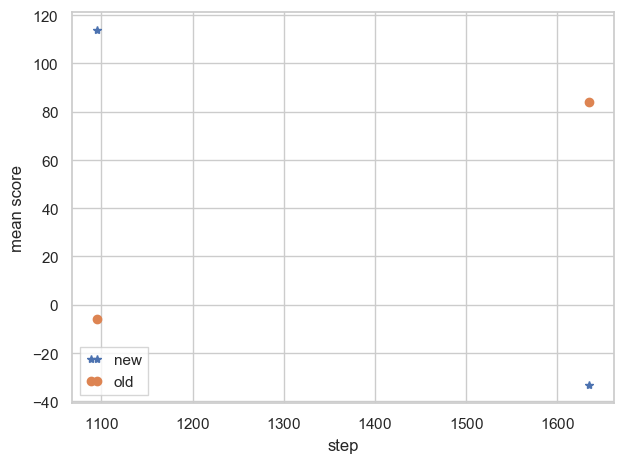

In [150]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER++_fd', scr=False)

In [151]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 310.4875087738037 ms
                 precision    recall  f1-score   support

        Whistle       0.80      1.00      0.89       183
          Tomte       0.96      0.36      0.52       189
Scattered_Light       0.68      0.98      0.81       166

       accuracy                           0.77       538
      macro avg       0.81      0.78      0.74       538
   weighted avg       0.82      0.77      0.73       538



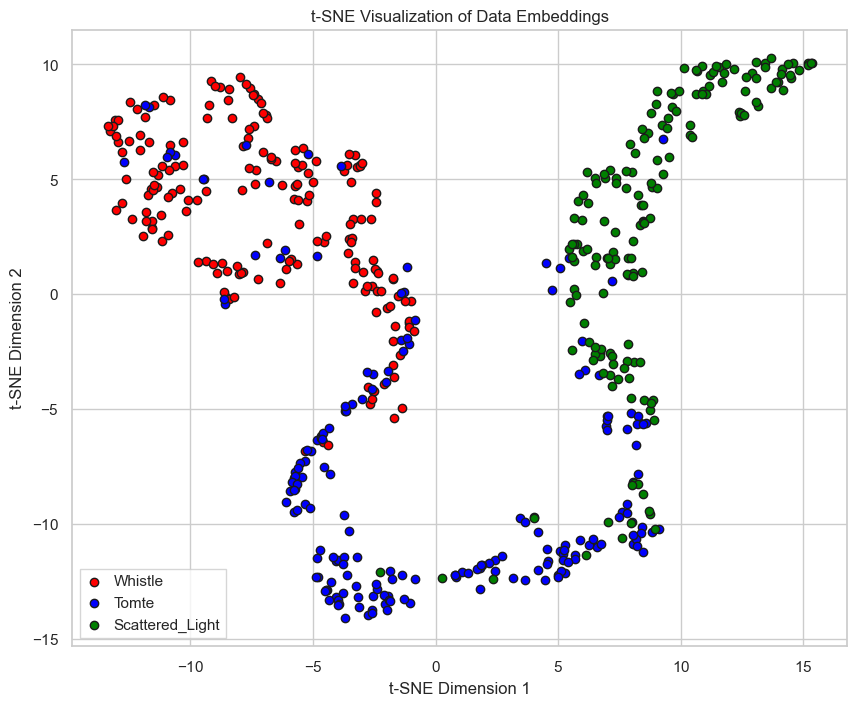

plot_tSNE_data_embedding: 1742.521047592163 ms


In [152]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_DER++_test.png")

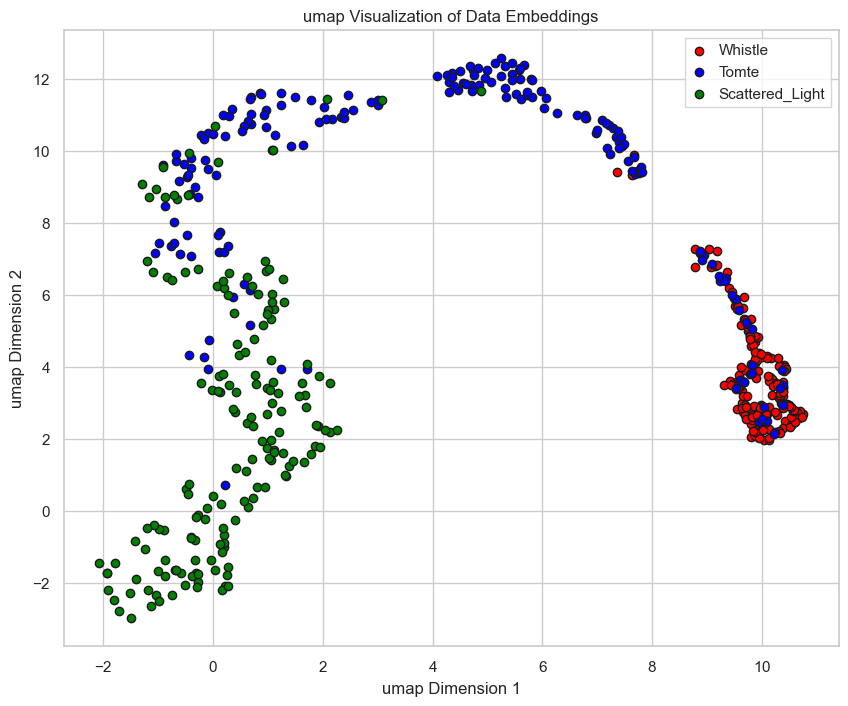

plot_umap_data_embedding: 7460.430383682251 ms


In [153]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_DER++_test.png")

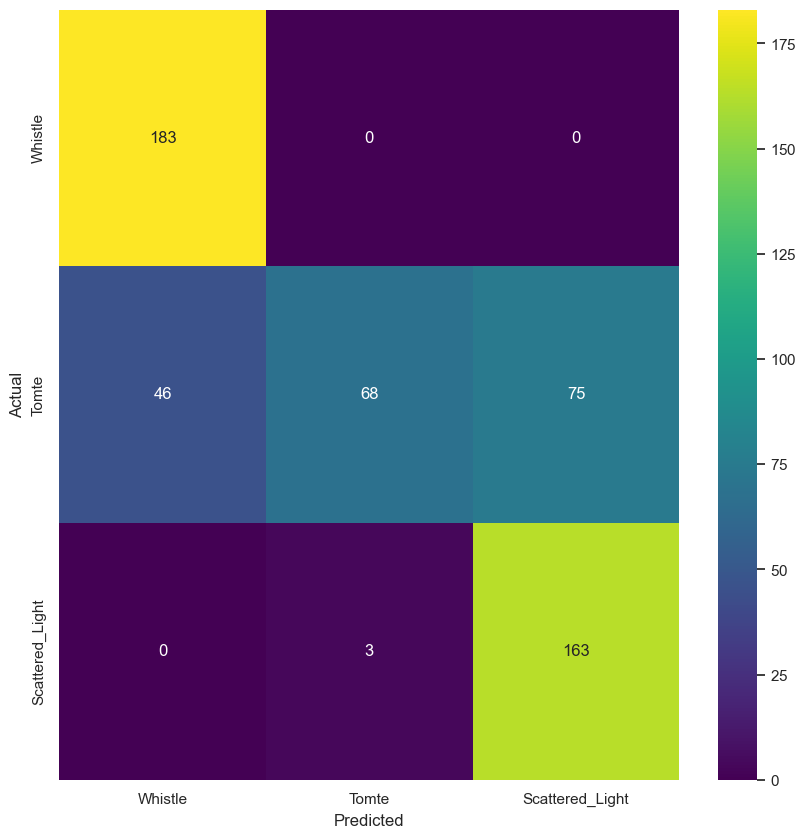

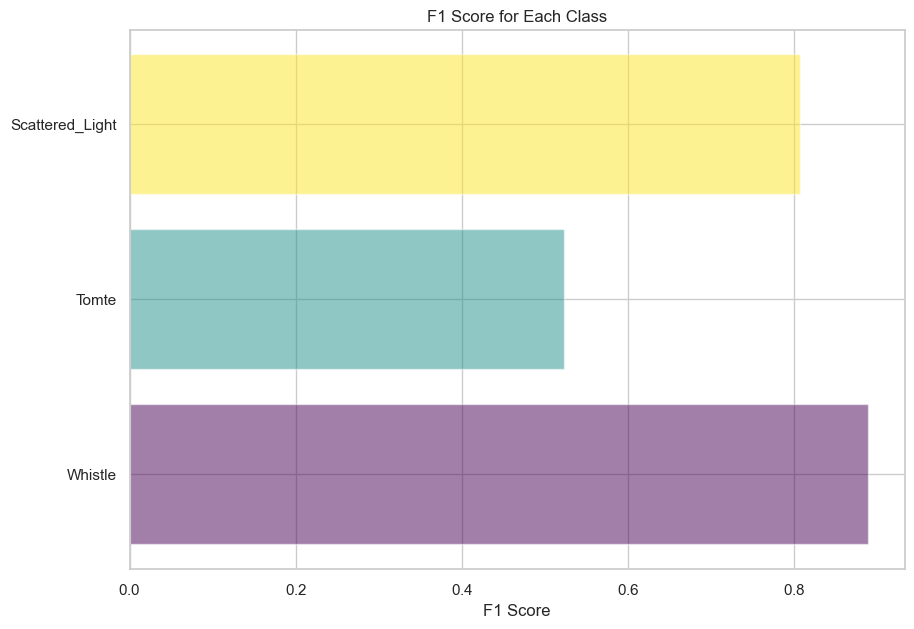

In [154]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_DER++.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_DER++.png')

## SCR Continual strategy

In [69]:
from avalanche.training import SCR, SCRLoss
from avalanche.models import SCRModel
extractor = my_architectures.FractalDimensionConvNet()
extractor.to(device)
projection = nn.Linear(3, 16)
projection.to(device)
scr_model = SCRModel(feature_extractor=extractor, projection=projection)
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = SCRLoss()
scr_model.to(device)

SCRModel(
  (ncm): NCMClassifier()
  (feature_extractor): FractalDimensionConvNet(
    (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=3584, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
    (fc3): Linear(in_featu

In [70]:
# SCR STRATEGY
cl_strategy = SCR(
    model=scr_model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=16, mem_size=1000, temperature=0.1, device=device, evaluator=eval_plugin
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    timing_metrics(experience=True, stream=True),
    #gpu_usage_metrics(device.index, every=0.5, epoch=True, experience=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

Starting experiment with strategy: <avalanche.training.supervised.supervised_contrastive_replay.SCR object at 0x000002A1ADF4F040>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [39:54<00:00, 66.51s/it]    
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 5.0341
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 36/36 [00:01<00:00, 19.27it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.9140
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 36/36 [00:01<00:00, 19.19it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.9048
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 36/36 [00:01<00:00, 18.68it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8997
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 36/36 [00:01<00:00, 19.15it/s]
Epoch 4 ended.
	Loss_Epoch/t

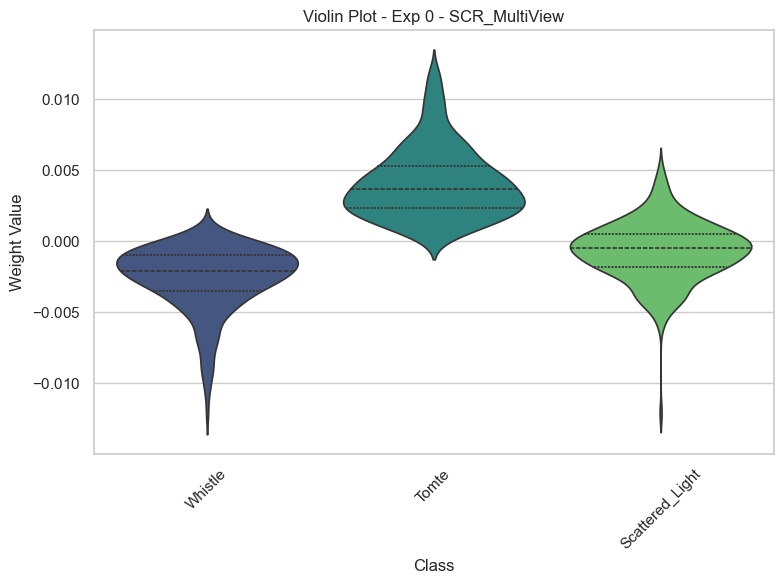

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:08<00:00,  4.62it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7160
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 37/37 [00:07<00:00,  4.70it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7148
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 37/37 [00:08<00:00,  4.25it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7126
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 37/37 [00:08<00:00,  4.32it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7078
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 37/37 [00:09<00:00,  3.97it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.6887
	MaxGPUNoneUsage_Epoch/train_phase/train_stream/Task000 = 0
100%|██████████| 37/37 [00:10<00:

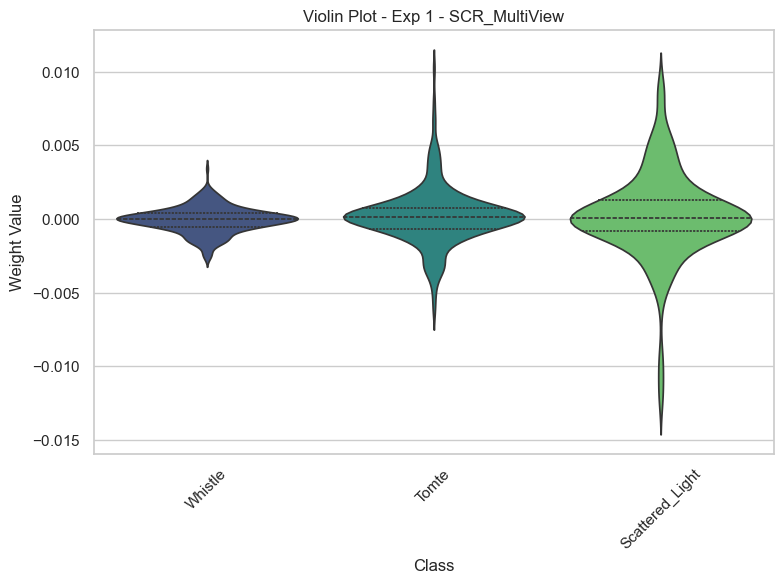

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 73.44it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6420
	MaxGPUNoneUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1351
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 76.81it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6482
	MaxGPUNoneUsage_Experience/eval_phase/test_stream/Task000/Exp001 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp001 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1307
	Top1_Acc_Exp/eval_phase/test_stre

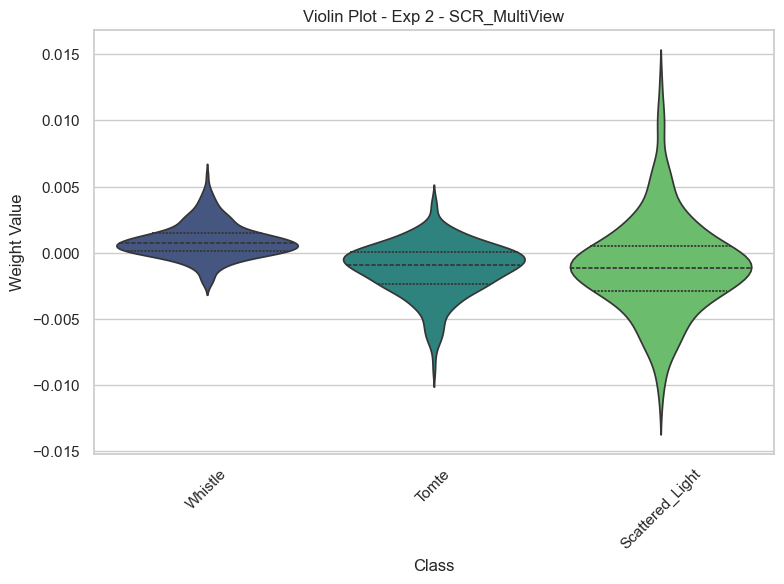

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 90.33it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7184
	MaxGPUNoneUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1104
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9931
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 83.08it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0134
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0134
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6564
	MaxGPUNoneUsage_Experience/eval_phase/test_stream/Task000/Exp001 = 0
	MaxRAMUsage_Experience/e

In [71]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers, classes, 'SCR_MultiView', scr=True)

In [72]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 243.2856559753418 ms
                 precision    recall  f1-score   support

        Whistle       0.94      0.96      0.95       183
          Tomte       0.93      0.85      0.89       189
Scattered_Light       0.91      0.96      0.94       166

       accuracy                           0.92       538
      macro avg       0.92      0.93      0.92       538
   weighted avg       0.92      0.92      0.92       538



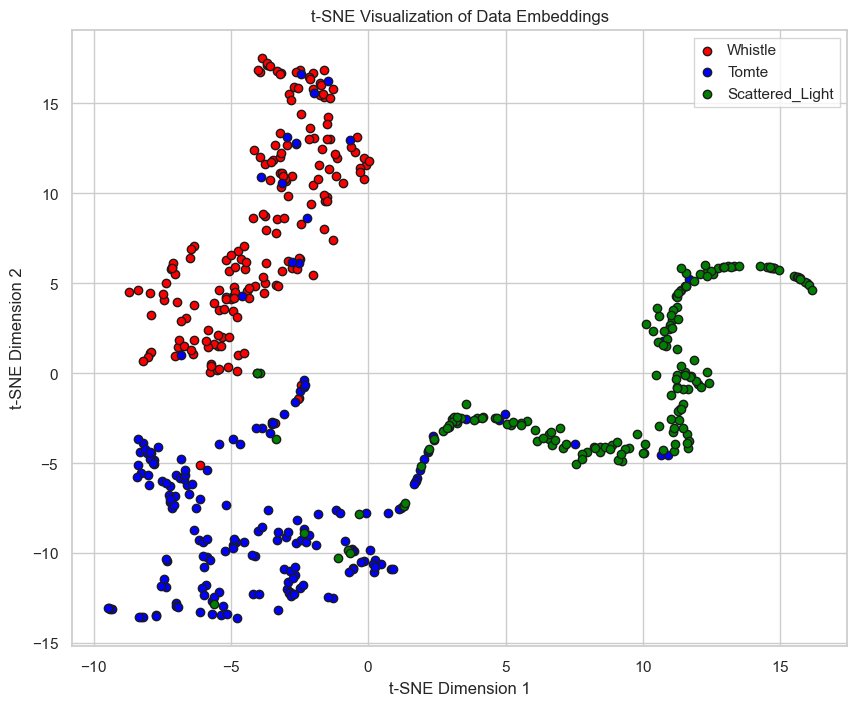

plot_tSNE_data_embedding: 1159.9063873291016 ms


In [58]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_SCR_test.png")

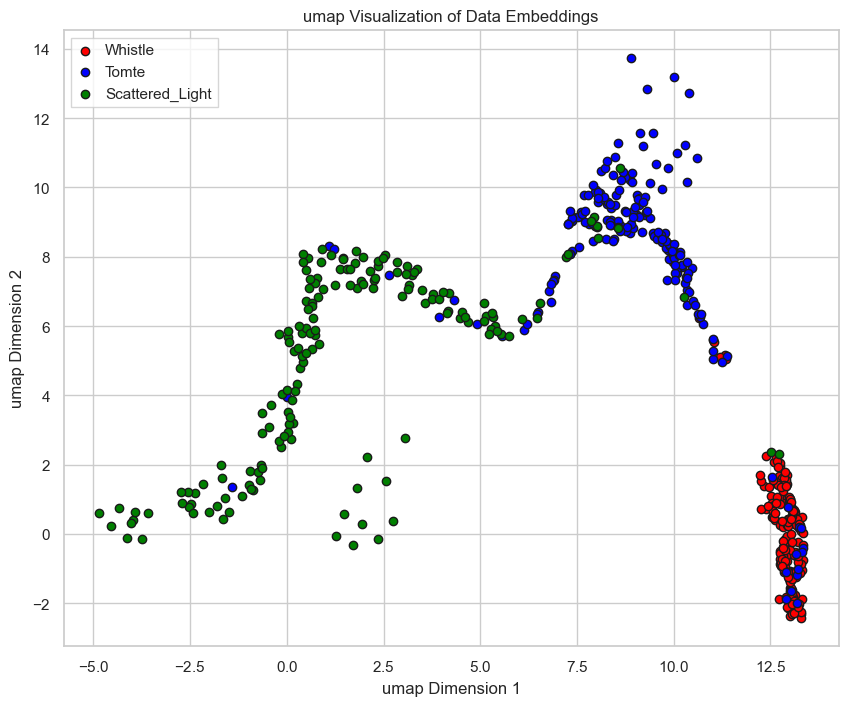

plot_umap_data_embedding: 7301.403760910034 ms


In [59]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_SCR_test.png")

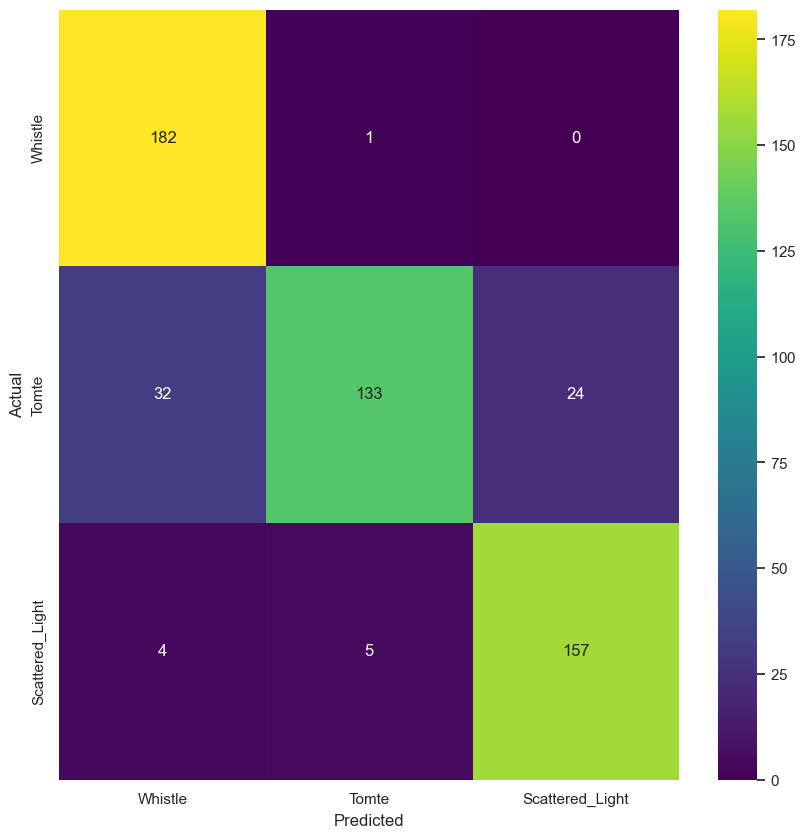

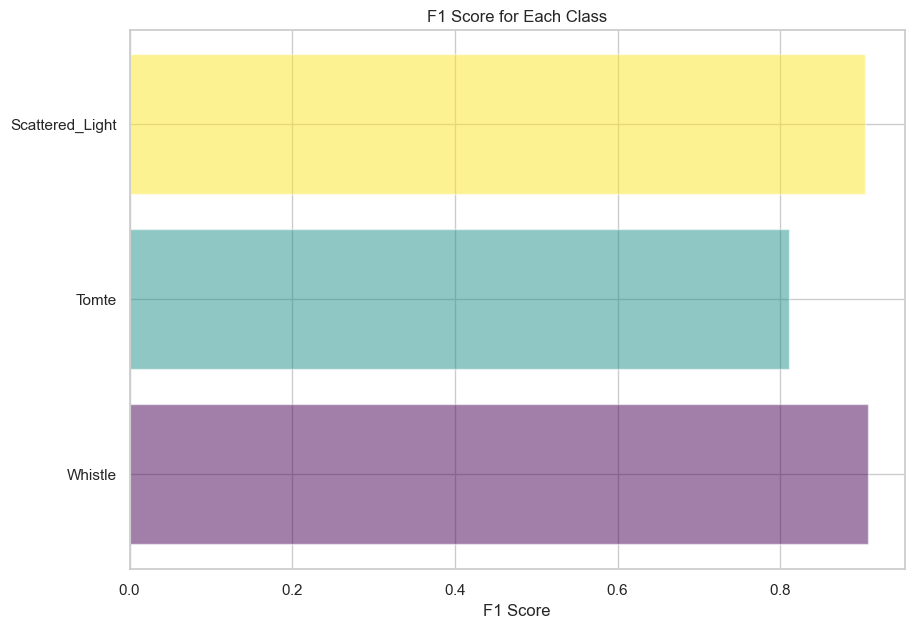

In [60]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_SCR.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_SCR.png')